# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

The optimization equation looks like this:
\begin{equation}
\label{eq:phase1}
{\{\hat{q_i}\}_{i=1}^N} = \operatorname*{arg\,min}_{\{\hat{q}_i\}_{i=1}^N} \sum_{i,j} \left| d_q(q_i, q_j) - d_q(\hat{q_i}, \hat{q_j}) \right|^2
\end{equation}

We start by random uniform distribution of angle triplets corresponding to the quaternion values $\hat{q_i}$ and $\hat{q_j}$ and we want to see if during the optimization we manage to estimate the true quaternions $q_i$ and $q_j$.


## Content

1. **5A1A** - symmetric protein:  
1.1. [Experiments Summary](#1.1.-Experiments-Summary---Losses-w.r.t.-Different-Variance-Values)  
1.2. [Data Preparation](#1.2.-Data-Preparation)  
1.3. [Angle Recovery with Perfect Distances](#1.3.-Angle-Recovery:-Perfect-Distance)  
1.4. [Angle Recovery with Perfect Distances and Variance 0.0](#1.4.-Angle-Recovery:-Variance-0.0)  
1.5. [Angle Recovery with Perfect Distances and Variance 0.2](#1.5.-Angle-Recovery:-Variance-0.2)  
1.6. [Angle Recovery with Perfect Distances and Variance 0.5](#1.6.-Angle-Recovery:-Variance-0.5)  
1.7. [Angle Recovery with Perfect Distances and Variance 0.8](#1.7.-Angle-Recovery:-Variance-0.8) 


2. **5J0N** - asymmetric protein:  
2.1. [Experiments Summary](#2.1.-Experiments-Summary---Losses-w.r.t.-Different-Variance-Values)  
2.2. [Data Preparation](#2.2.-Data-Preparation)  
2.3. [Angle Recovery with Perfect Distances](#2.3.-Angle-Recovery:-Perfect-Distance)  
2.4. [Angle Recovery with Perfect Distances and Variance 0.0](#2.4.-Angle-Recovery:-Variance-0.0)  
2.5. [Angle Recovery with Perfect Distances and Variance 0.2](#2.5.-Angle-Recovery:-Variance-0.2)  
2.6. [Angle Recovery with Perfect Distances and Variance 0.5](#2.6.-Angle-Recovery:-Variance-0.5)  
2.7. [Angle Recovery with Perfect Distances and Variance 0.8](#2.7.-Angle-Recovery:-Variance-0.8) 

In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import ipyvolume as ipv
import tensorflow as tf

import sys
sys.path.append("../..") 
from cryoem.plots import (plot_angles_count, plot_euclidean_space, save_space_plot,
                        plot_selected_angles_with_3rd_angle_magnitude, 
                        plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, 
                        plot_rays, plot_images, plot_angles_with_3rd_angle_magnitude, plot_distances_count)
from cryoem.conversions import d_q, quaternion2euler, euler2quaternion, distance_difference
from cryoem.angle_alignment import training_angle_alignment,update_quaternion

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17298292810325864182
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5952369435221854833
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15598353721307175166
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3183017984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1355794998977608815
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


---

Code for AR, put temp. Remove to proj.code later.

In [3]:
# QUATERNION VARIABLE
import time
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion

def train_angle_recovery(steps, batch_size, projection_idx, 
                        in_data, distance_fn, angles_predicted=None,
                        learning_rate=0.01, 
                        optimization=False): 
    time_start = time.time()
    
    optimizer = Adam(learning_rate=learning_rate)
    
    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))
    q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]
#     q_predicted = [tf.Variable(tf.cast(quaternion.normalized_random_uniform((1,)), dtype=tf.float64)) for _ in range(len(in_data))]
    
    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)
    
    losses = np.empty(steps)
    report = ""
    found_minimizer = False
    
    print(time.time()-time_start)
    
    for step, idx1, idx2 in sample_iter(steps, projection_idx, batch_size, style="random"):
        #q_predicted = quaternion.normalize(q_predicted)
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        
        distance_target = distance_fn(in1, in2)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(q1, q2, distance_target)
            optimizer.apply_gradients(zip(gradients, q1 + q2))
            
            # Visualize progress periodically
            if step % 10 == 0:
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(1, 3, figsize=(24,7))

                # Optimization loss subplot
                axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[0].set_xlabel('time [s]')
                axs[0].set_ylabel('loss');
                axs[0].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # T - Distance count subplot (full)
                d2 = d_q(in_data, q_predicted)
                axs[1].set_xlim(0, np.pi)
                axs[1].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                
                # NT - Distance count subplot (full)
                d2 = d_q(in_data, euler2quaternion(quaternion2euler(q_predicted, transposed=False)))
                axs[2].set_xlim(0, np.pi)
                axs[2].set_title(f"FULL: [{step}/{steps}] NOT TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(1.0)
                
                if found_minimizer:
                    break;
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
            
        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True
            
    print(report)
    return quaternion.normalize(q_predicted)
        
def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")
        
        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
    
        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            
            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random
        
        yield step, idx1, idx2
        
def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient


---

### 1.1. Experiment Summary

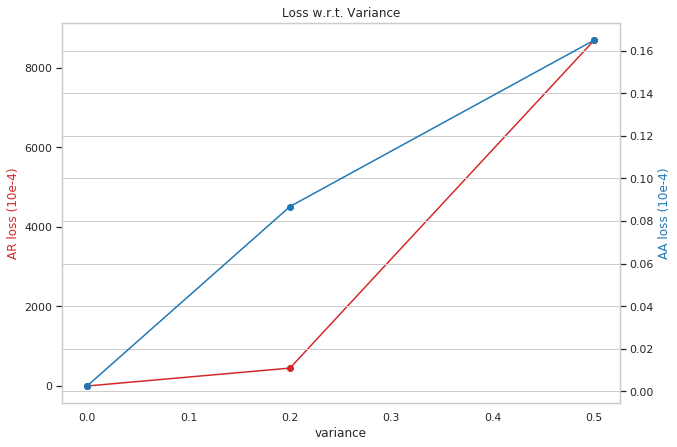

In [71]:
# losses
variances = [0.0, 0.2, 0.5]
losses = np.array([6.94e-07, 4.5e-02, 8.69e-01])
aa_losses = np.array([2.47e-03, 8.68e-02, 1.65e-01])
scale_degree = 4
losses = losses * 10**scale_degree

# # d_Q before alignment
# d_Q_before = np.array([1.827, 0.806, 2.075])

# # d_Q after alignment
# d_Q_after = np.array([0.786, 0.800, 0.285])


fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(variances, losses, marker="o", color='tab:red')
ax.set(xlabel='variance', title='Loss w.r.t. Variance')
ax.set_ylabel(f'AR loss (10e{-scale_degree})', color='tab:red')
ax.grid()

ax2 = ax.twinx()
ax2.plot(variances, aa_losses, marker="o", color='tab:blue')
ax2.set_ylabel(f'AA loss (10e{-scale_degree})', color='tab:blue')

#fig.savefig("test.png")
plt.show()

### 1.2. Data Preparation

In [4]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [5]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [6]:
projections = data['Projections']

In [7]:
# np.savez("5a1a_projections_and_angles", projections, data['Angles'])

#### True Angles

(5000, 3)


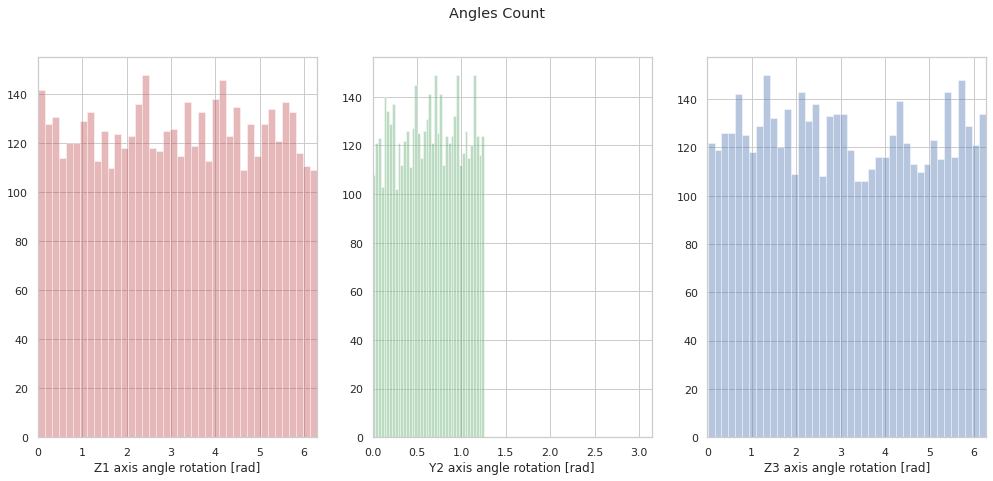

In [8]:
angles_true = np.array(data['Angles'])
print(angles_true.shape)
plot_angles_count(angles_true)

---

---

### 1.3. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [8]:
# from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [9]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [10]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

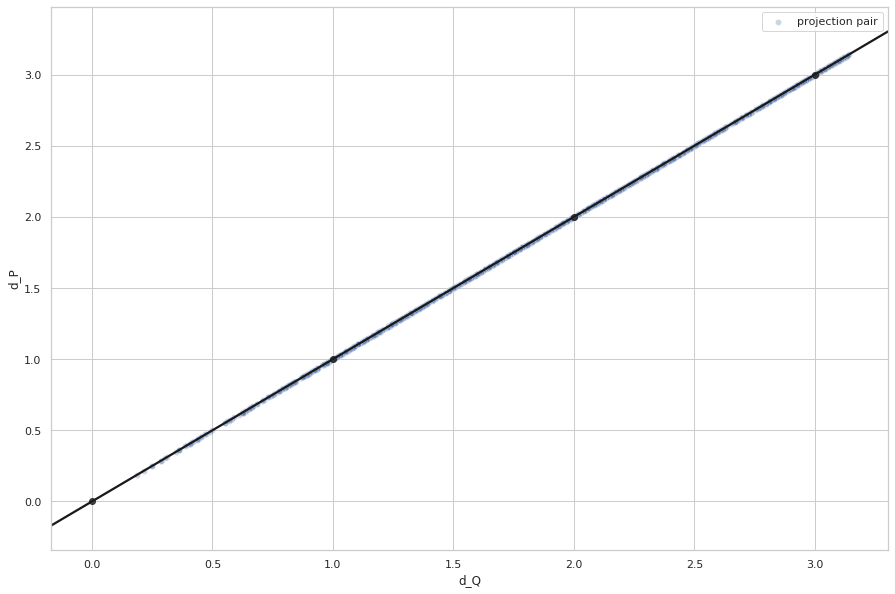

In [11]:
plot_dP_dQ(dP_values, dQ_values);

<Figure size 432x288 with 0 Axes>

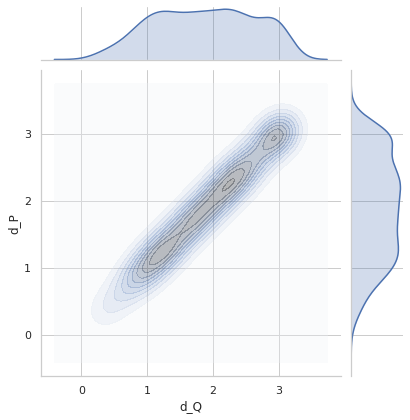

In [12]:
plot_dP_dQ_density(dP_values, dQ_values);

In [13]:
# variance
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.0

#### Angle Recovery

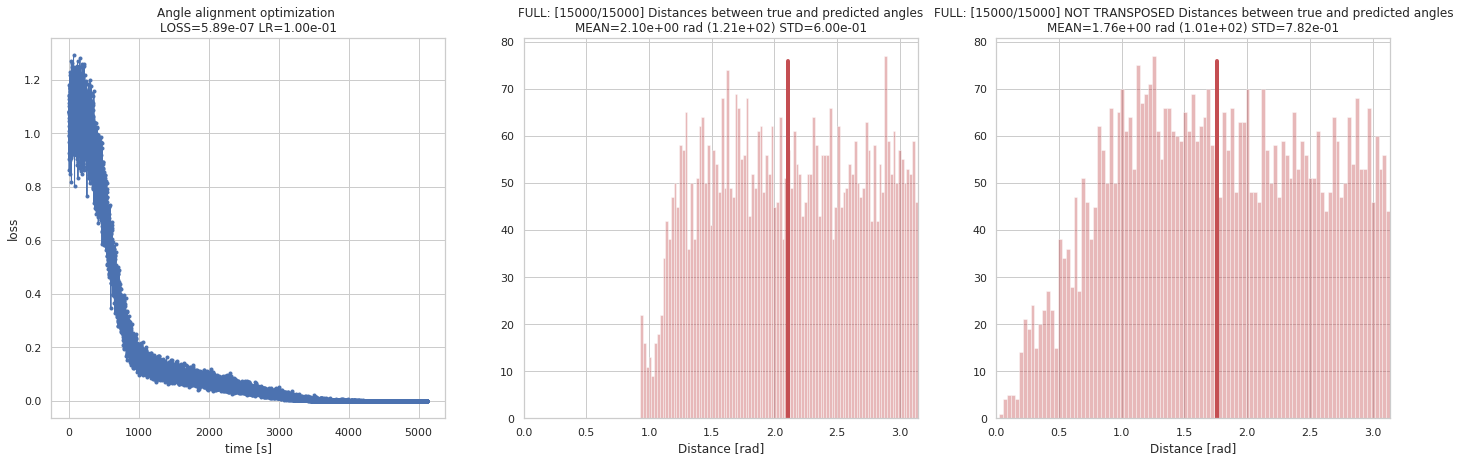

step 1500/15000 (502s): loss = 7.30e-01
step 3000/15000 (1000s): loss = 1.34e-01
step 4500/15000 (1502s): loss = 1.27e-01
step 6000/15000 (2014s): loss = 6.78e-02
step 7500/15000 (2519s): loss = 3.61e-02
step 9000/15000 (3028s): loss = 2.28e-02
step 10500/15000 (3534s): loss = 1.09e-03
step 12000/15000 (4056s): loss = 7.79e-05
step 13500/15000 (4600s): loss = 1.12e-05
step 15000/15000 (5176s): loss = 6.94e-07



In [19]:
q_predicted = train_angle_recovery(steps=15000, 
                                 batch_size=256, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [52]:
# np.save("data/predicted_quaternions2", qp.numpy())

In [16]:
qp = np.load("data/predicted_quaternions2.npy")

In [45]:
transposed = True
if not transposed:
    ap = quaternion2euler(qp, transposed=False)
else:
    ap = quaternion2euler(qp, transposed=True)

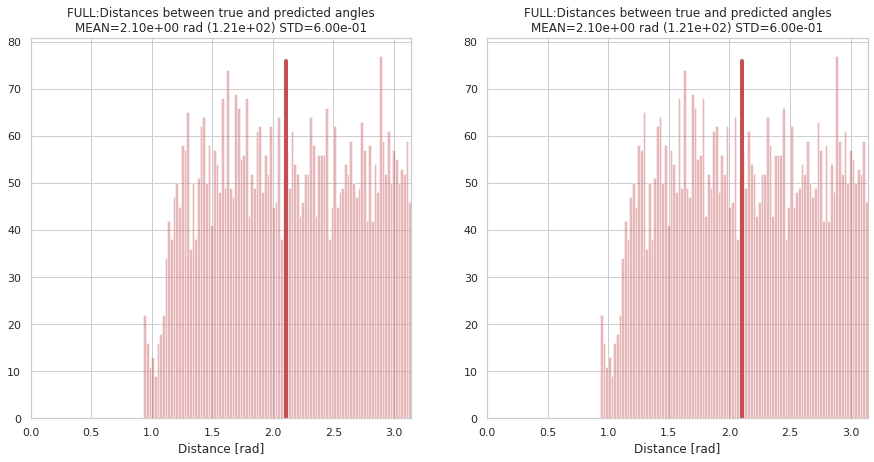

In [51]:
# check: both plots should be the same
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(quaternion2euler(qp)))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

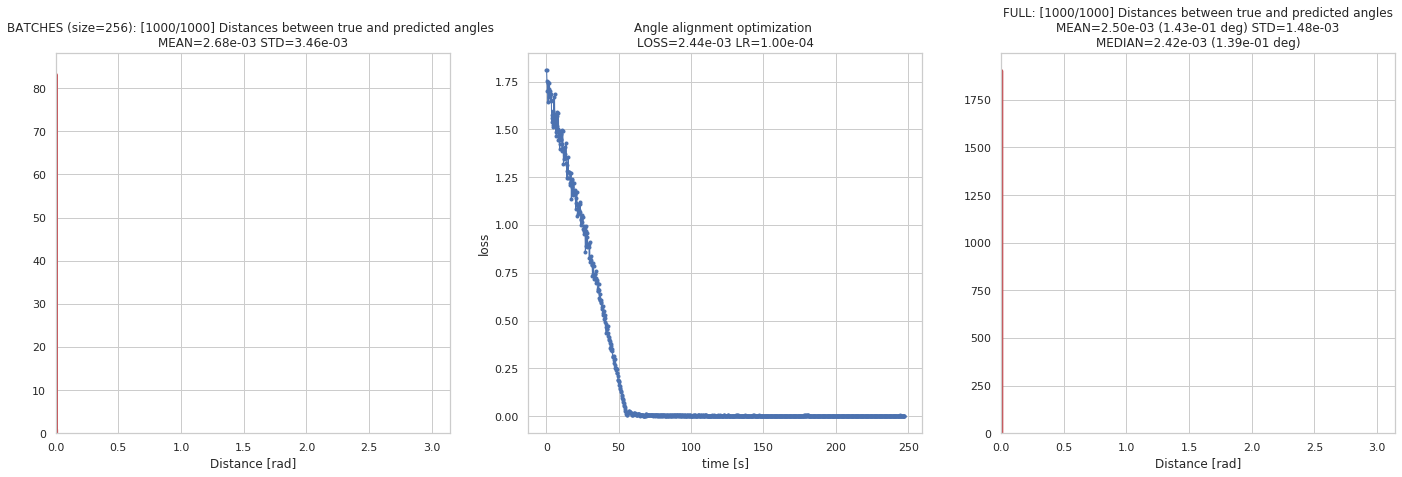

step 100/1000 (25s): loss = 1.38e+00
step 200/1000 (50s): loss = 6.24e-01
step 300/1000 (75s): loss = 3.18e-02
step 400/1000 (100s): loss = 3.92e-03
step 500/1000 (125s): loss = 3.07e-03
step 600/1000 (150s): loss = 2.78e-03
step 700/1000 (175s): loss = 2.61e-03
step 800/1000 (200s): loss = 2.24e-03
step 900/1000 (225s): loss = 2.50e-03
step 1000/1000 (249s): loss = 2.47e-03



In [21]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

In [24]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([7.46193109, 5.72991295, 3.4938722 , 0.07887967, 5.70293041,
        3.82260403]),
 0.0024665159599501097)

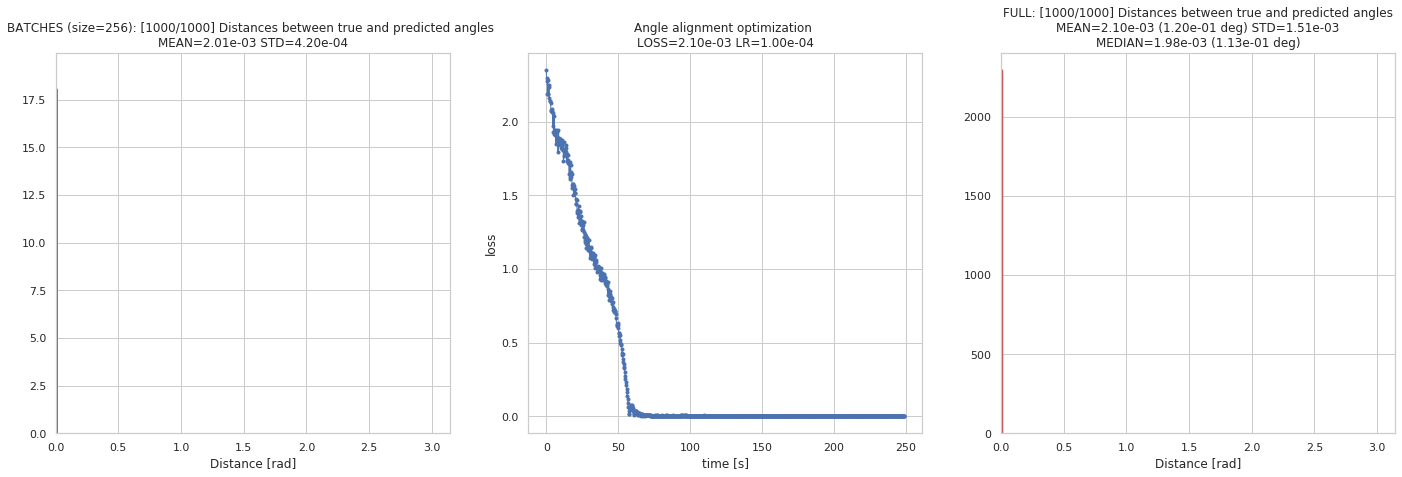

step 100/1000 (26s): loss = 1.78e+00
step 200/1000 (51s): loss = 9.80e-01
step 300/1000 (76s): loss = 1.24e-01
step 400/1000 (101s): loss = 3.41e-03
step 500/1000 (125s): loss = 3.08e-03
step 600/1000 (150s): loss = 2.86e-03
step 700/1000 (175s): loss = 2.68e-03
step 800/1000 (200s): loss = 2.55e-03
step 900/1000 (225s): loss = 2.48e-03
step 1000/1000 (251s): loss = 2.38e-03



In [27]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

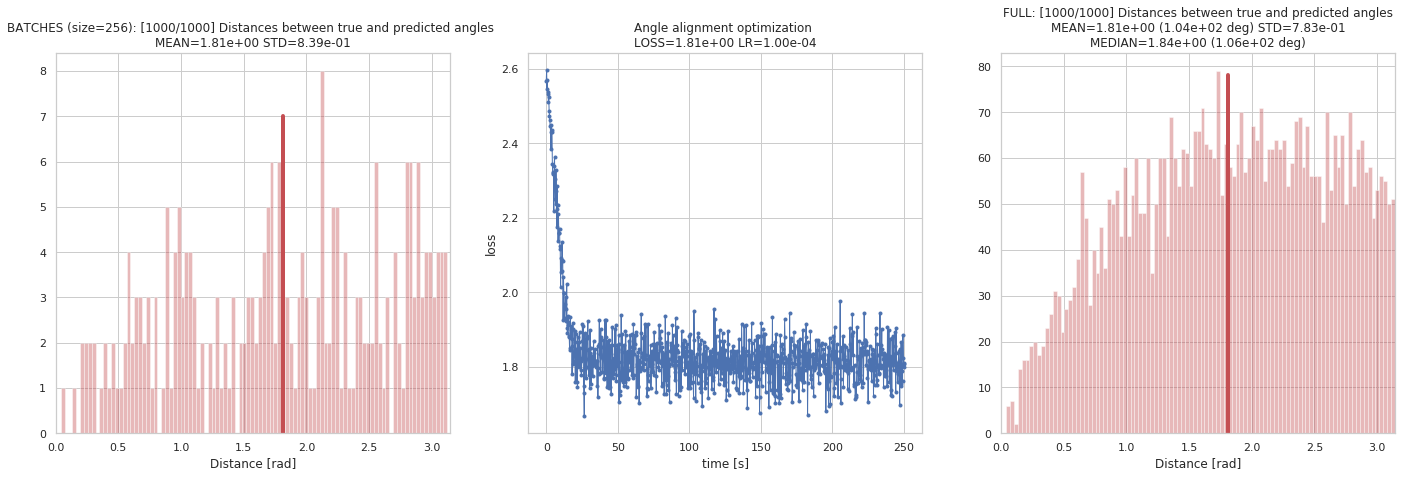

step 100/1000 (25s): loss = 2.08e+00
step 200/1000 (51s): loss = 1.82e+00
step 300/1000 (76s): loss = 1.82e+00
step 400/1000 (101s): loss = 1.82e+00
step 500/1000 (127s): loss = 1.81e+00
step 600/1000 (152s): loss = 1.81e+00
step 700/1000 (177s): loss = 1.81e+00
step 800/1000 (202s): loss = 1.81e+00
step 900/1000 (227s): loss = 1.81e+00
step 1000/1000 (252s): loss = 1.81e+00



In [29]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

In [30]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([6.39449883, 3.72992697, 3.44321025, 3.60267126, 2.73801654,
        2.74985574]),
 1.8129233472117061)

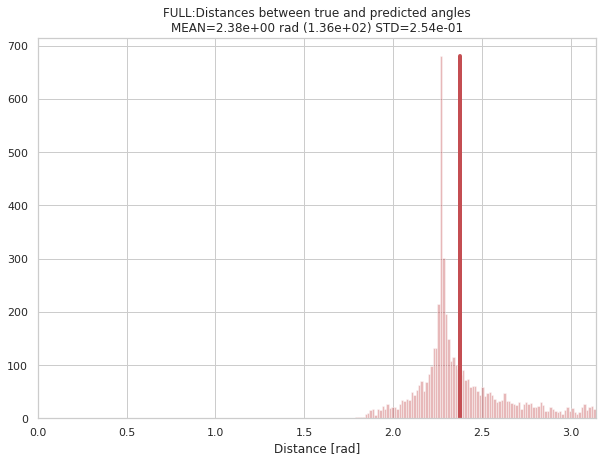

In [44]:
# TODO: explore this further, maybe AA part should also search for both T and not T 
uqp = update_quaternion(m, rotation, qp)

fig, axs = plt.subplots(1, 1, figsize=(10,7))
d2 = d_q(euler2quaternion(angles_true), euler2quaternion(quaternion2euler(uqp, transposed=False)))
axs.set_xlim(0, np.pi)
axs.set_title(f"FULL:Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs, axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs.plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

---

### 1.4. Angle Recovery: Variance 0.0

#### dP/dQ plot

In [9]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [10]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.0, dtype=tf.float64)
    return norm_distr  

In [37]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)#.T[0]
dQ_values = d_q(q1_true, q2_true)#.numpy()

<Figure size 432x288 with 0 Axes>

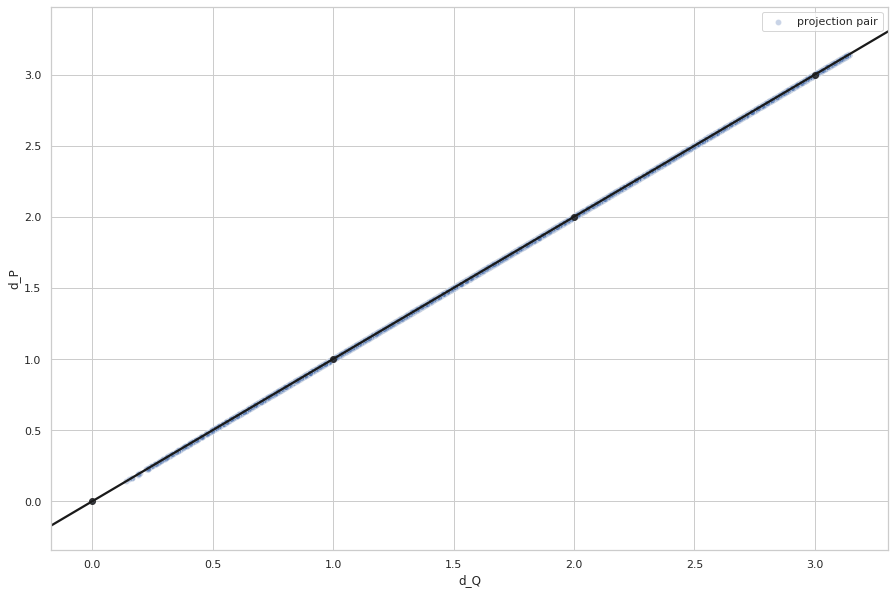

In [38]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

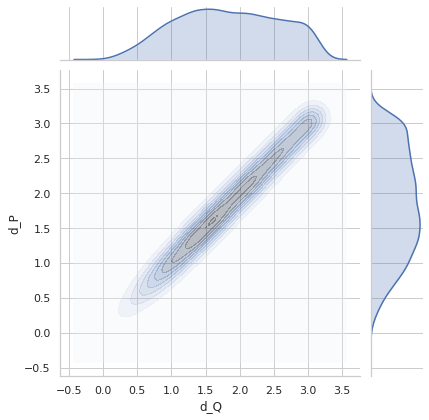

In [39]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

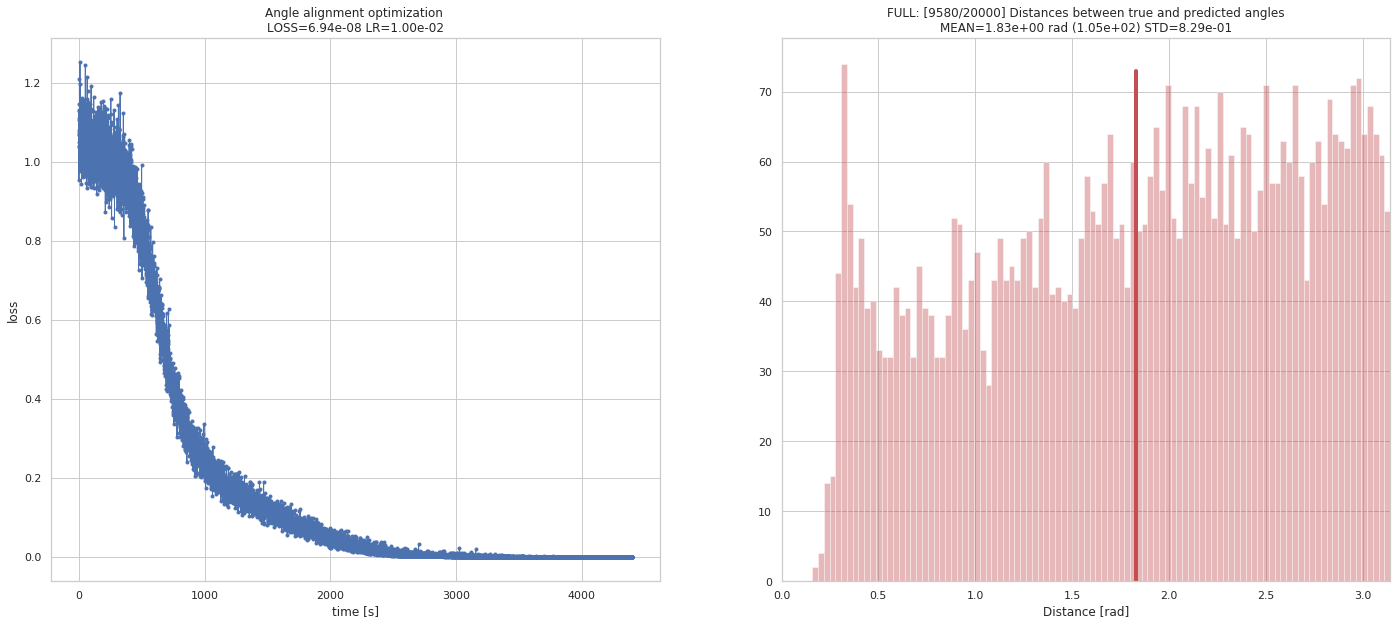

step 2000/20000 (895s): loss = 2.69e-01
step 4000/20000 (1763s): loss = 6.09e-02
step 6000/20000 (2683s): loss = 9.27e-04
step 8000/20000 (3621s): loss = 4.00e-06



In [44]:
q_predicted = train_angle_recovery(steps=20000, 
                                         batch_size=512, 
                                         projection_idx=range(NUM_PROJECTIONS), 
                                         in_data=angles_true, 
                                         distance_fn=d_p, 
                                         learning_rate=0.01, 
                                         optimization=True)

Mean `quaternion` distance between true and predicted values: 1.867 rad (106.956 degrees)


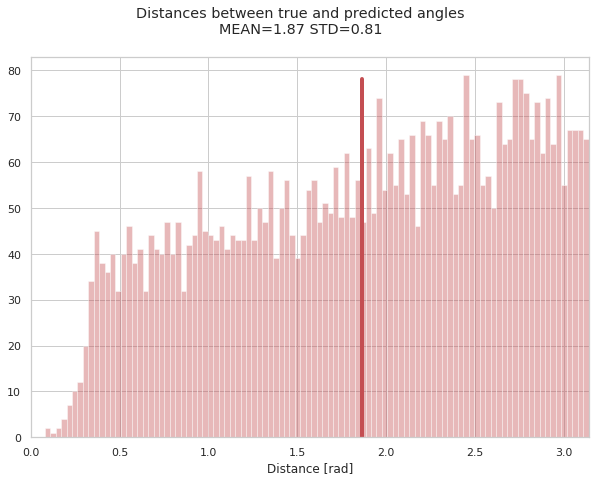

In [45]:
a_predicted = quaternion2euler(q_predicted, transposed=True)
distance_difference(angles_predicted=a_predicted, angles_true=angles_true);
plot_distances_count(a_predicted, angles_true);

Mean `quaternion` distance between true and predicted values: 2.869 rad (164.375 degrees)


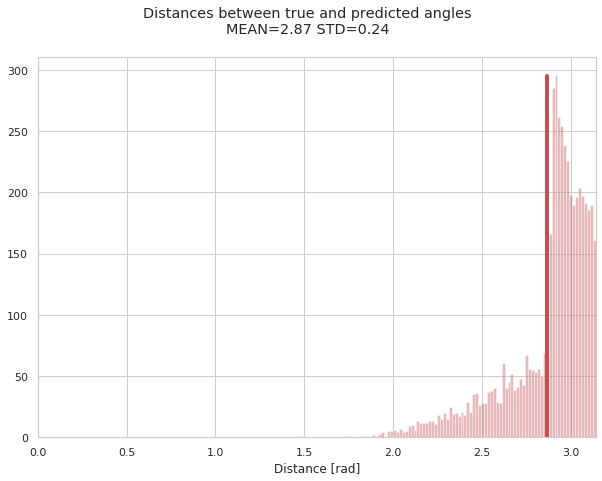

In [46]:
a_predicted = quaternion2euler(q_predicted, transposed=False)
distance_difference(angles_predicted=a_predicted, angles_true=angles_true);
plot_distances_count(a_predicted, angles_true);

In [48]:
# ang_save = np.zeros((len(a_predicted),3))
# for i, a in enumerate(a_predicted):
#     ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.npy", a_predicted)

In [49]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_var0.npy")

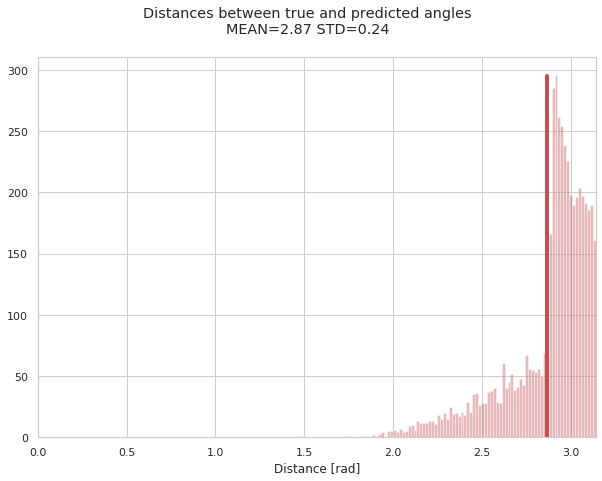

In [51]:
plot_distances_count(ap, angles_true);

### Angle Alignment

---

### 1.5. Angle Recovery: Variance 0.2

#### dP/dQ plot

In [11]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.2, dtype=tf.float64)
    return norm_distr  

In [12]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

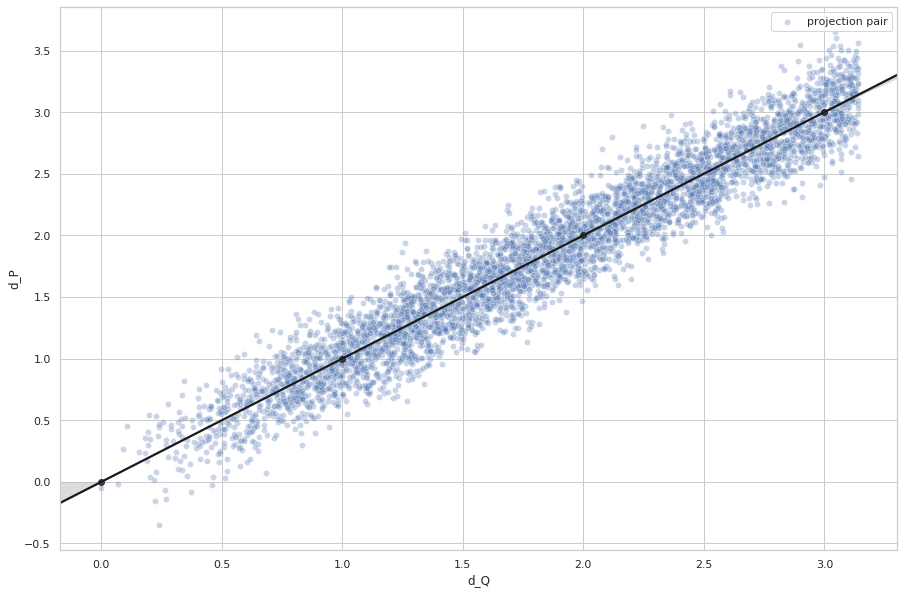

In [13]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

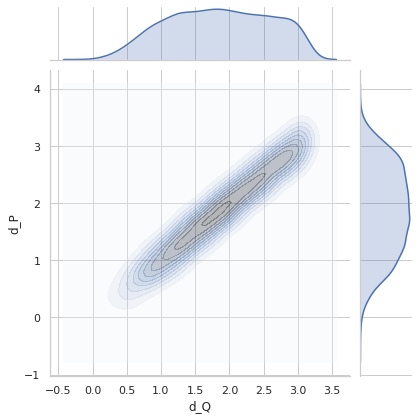

In [14]:
plot_dP_dQ_density(dP_values, dQ_values)

In [15]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.1995883467785799

#### Angle Recovery

In [11]:
# Try smaller variance until it is possible to converge

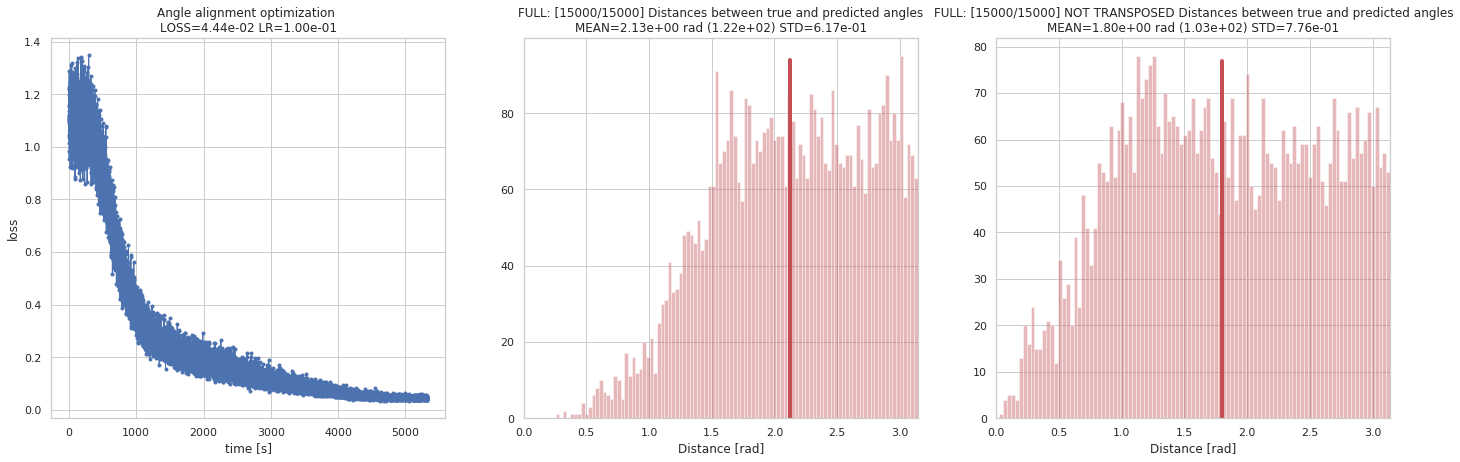

step 1500/15000 (506s): loss = 8.10e-01
step 3000/15000 (1002s): loss = 4.41e-01
step 4500/15000 (1508s): loss = 2.63e-01
step 6000/15000 (2022s): loss = 2.33e-01
step 7500/15000 (2539s): loss = 1.41e-01
step 9000/15000 (3082s): loss = 8.91e-02
step 10500/15000 (3621s): loss = 6.08e-02
step 12000/15000 (4188s): loss = 5.08e-02
step 13500/15000 (4756s): loss = 4.87e-02
step 15000/15000 (5325s): loss = 4.50e-02



In [14]:
q_predicted = train_angle_recovery(steps=15000, 
                                 batch_size=256, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [15]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/predicted_quaternions_var0.2.npy", q_save)

In [16]:
qp = np.load("data/predicted_quaternions_var0.2.npy")

In [23]:
transposed = False
if not transposed:
    ap = quaternion2euler(qp, transposed=False)
else:
    ap = quaternion2euler(qp, transposed=True)

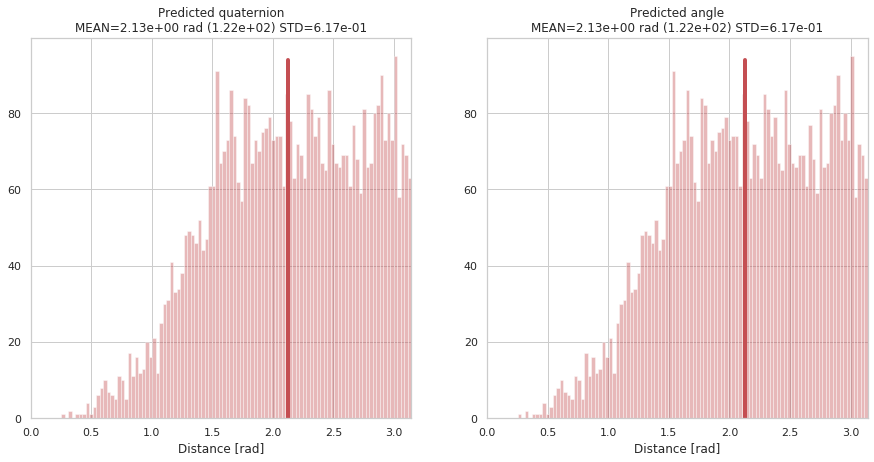

In [24]:
# check: both plots should be the same
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(quaternion2euler(qp)))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

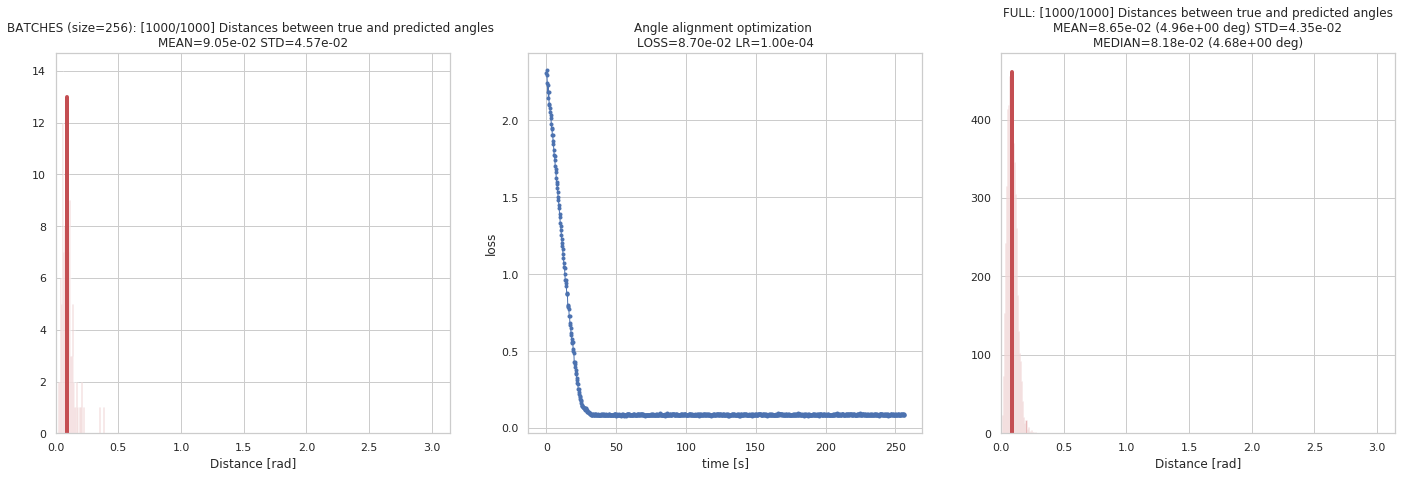

step 100/1000 (26s): loss = 1.14e+00
step 200/1000 (51s): loss = 9.40e-02
step 300/1000 (77s): loss = 8.62e-02
step 400/1000 (104s): loss = 8.67e-02
step 500/1000 (130s): loss = 8.66e-02
step 600/1000 (156s): loss = 8.65e-02
step 700/1000 (180s): loss = 8.69e-02
step 800/1000 (206s): loss = 8.66e-02
step 900/1000 (232s): loss = 8.74e-02
step 1000/1000 (258s): loss = 8.68e-02



In [25]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

In [26]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([0.34165653, 2.93198449, 2.48671378, 3.02052687, 4.1322292 ,
        5.04966415]),
 0.08673242881329324)

KeyboardInterrupt: 

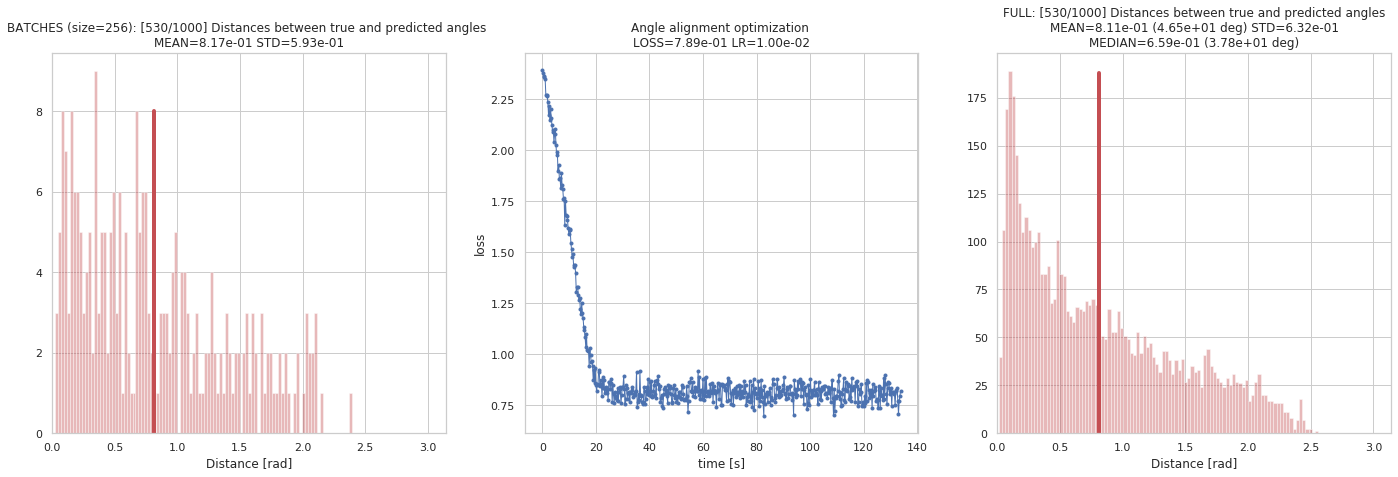

In [20]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

---

### 1.6. Angle Recovery: Variance 0.5

#### dP/dQ plot

In [21]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.5, dtype=tf.float64)
    return norm_distr  

In [22]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

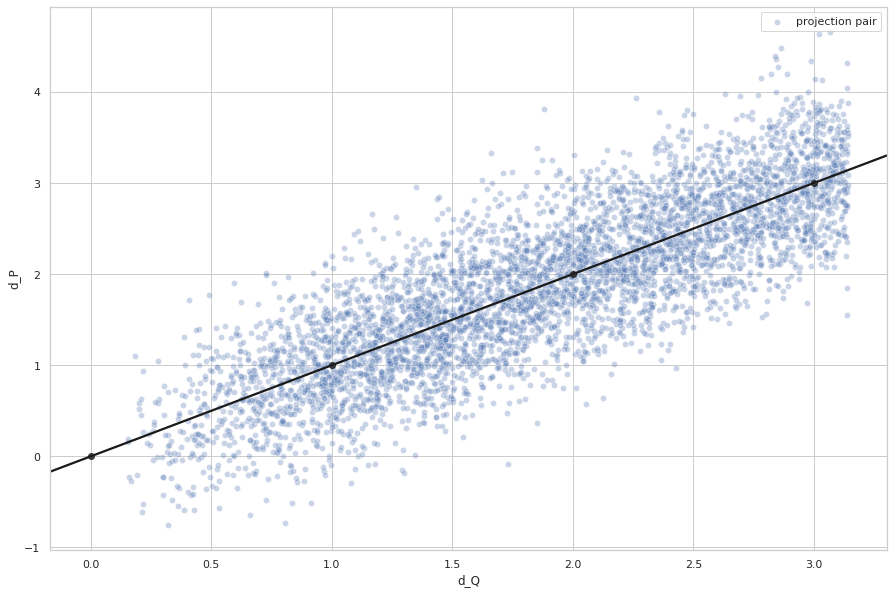

In [23]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

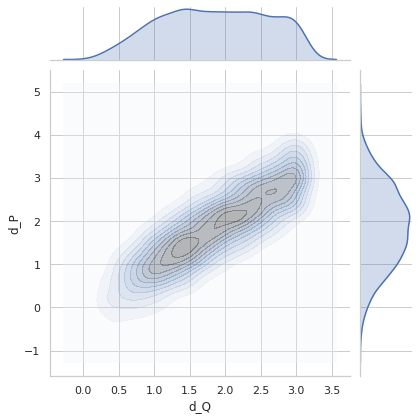

In [24]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [25]:
# Try smaller variance until it is possible to converge

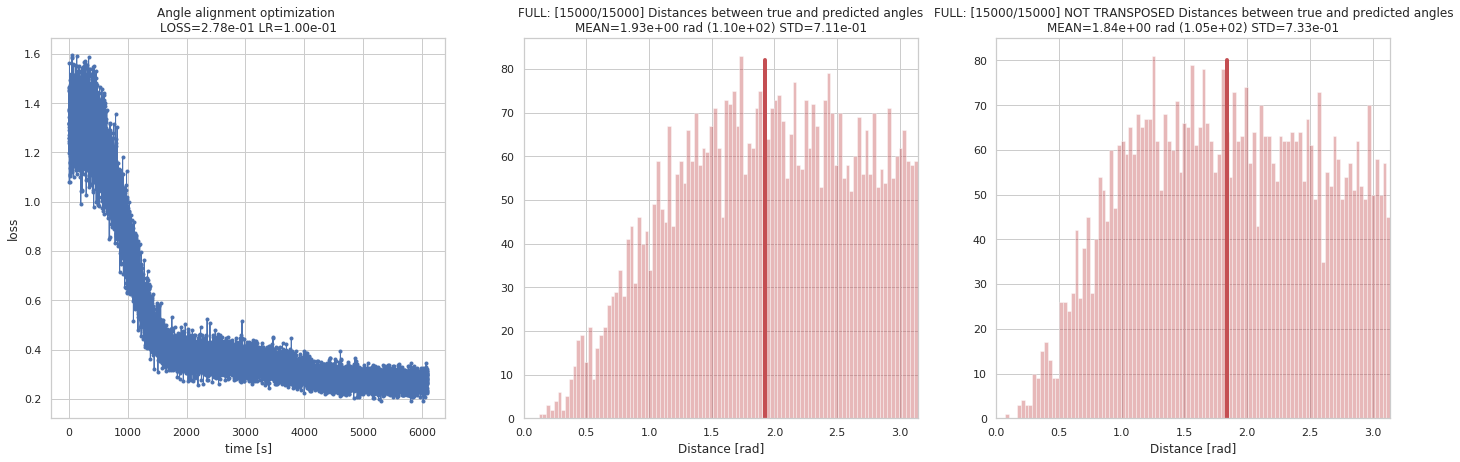

step 1500/15000 (619s): loss = 1.06e+00
step 3000/15000 (1171s): loss = 6.96e-01
step 4500/15000 (1741s): loss = 3.71e-01
step 6000/15000 (2309s): loss = 3.48e-01
step 7500/15000 (2900s): loss = 3.46e-01
step 9000/15000 (3486s): loss = 3.30e-01
step 10500/15000 (4094s): loss = 2.96e-01
step 12000/15000 (4767s): loss = 2.71e-01
step 13500/15000 (5426s): loss = 2.88e-01
step 15000/15000 (6091s): loss = 2.75e-01



In [26]:
q_predicted = train_angle_recovery(steps=15000, 
                                 batch_size=256, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [27]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/predicted_quaternions_var0.5.npy", q_save)

In [27]:
qp = np.load("data/predicted_quaternions_var0.5.npy")

In [35]:
transposed = False
if not transposed:
    ap = quaternion2euler(qp, transposed=False)
else:
    ap = quaternion2euler(qp, transposed=True)

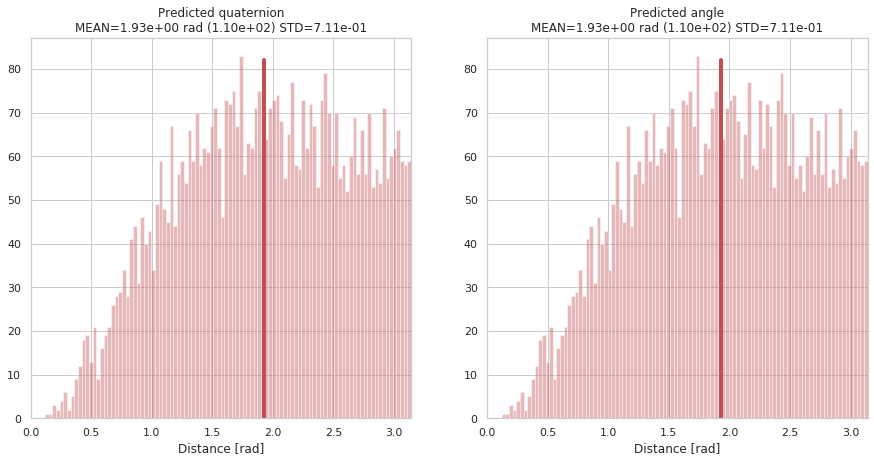

In [36]:
# check: both plots should be the same
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(quaternion2euler(qp)))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

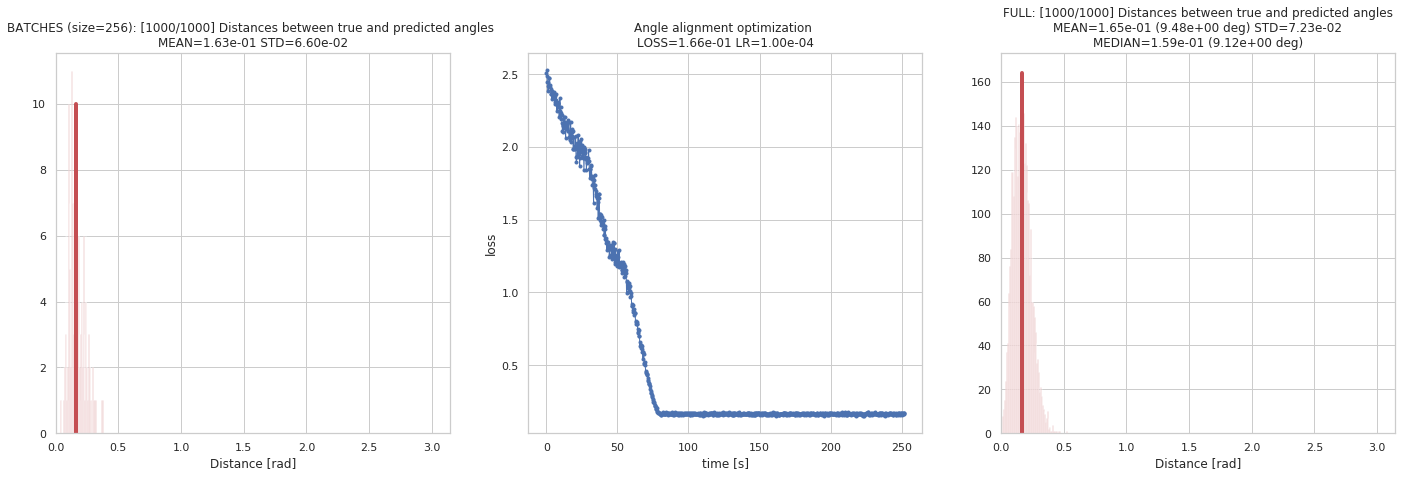

step 100/1000 (25s): loss = 2.19e+00
step 200/1000 (51s): loss = 1.58e+00
step 300/1000 (76s): loss = 7.96e-01
step 400/1000 (101s): loss = 1.71e-01
step 500/1000 (127s): loss = 1.65e-01
step 600/1000 (152s): loss = 1.65e-01
step 700/1000 (177s): loss = 1.65e-01
step 800/1000 (203s): loss = 1.65e-01
step 900/1000 (228s): loss = 1.65e-01
step 1000/1000 (253s): loss = 1.65e-01



In [37]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

In [38]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([8.03045757, 3.11211117, 3.5817019 , 6.30497779, 6.26448995,
        7.08032794]),
 0.1650169143299486)

---

### 1.7. Angle Recovery: Variance 0.8

#### dP/dQ plot

In [39]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [40]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

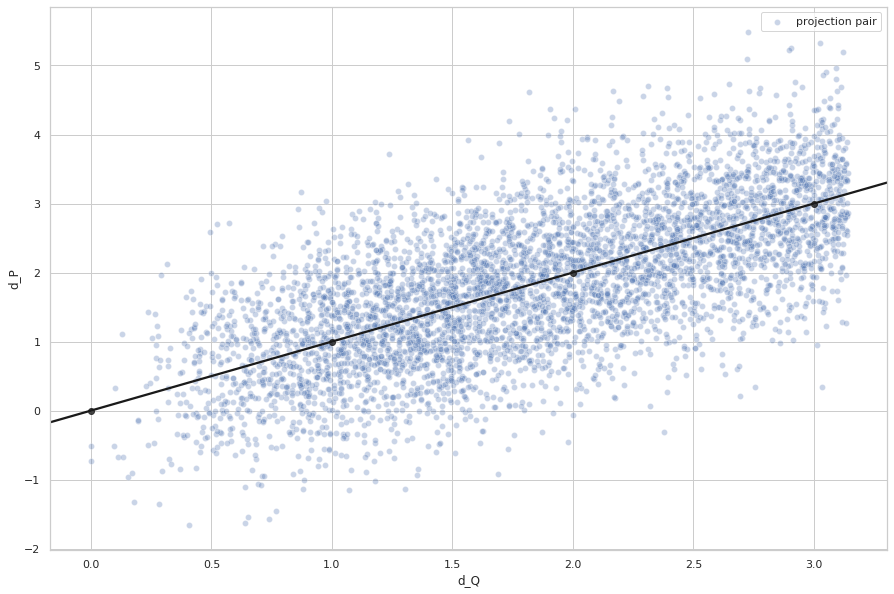

In [41]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

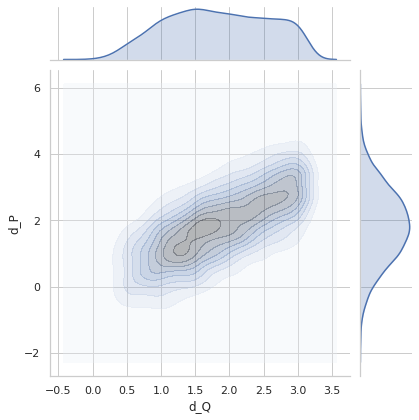

In [42]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [32]:
# Try smaller variance until it is possible to converge

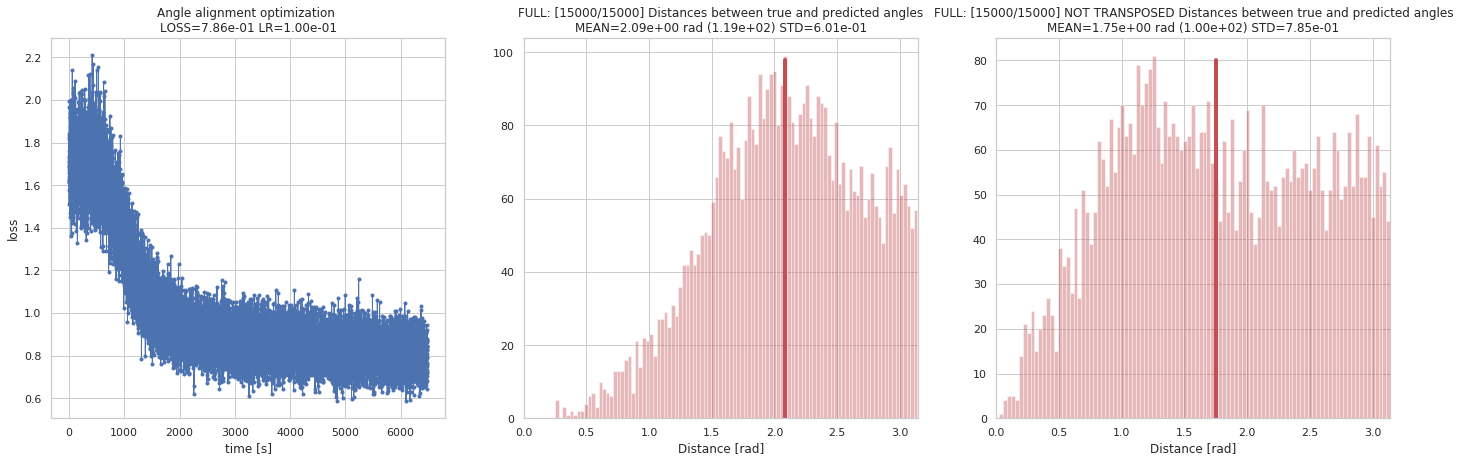

step 1500/15000 (589s): loss = 1.71e+00
step 3000/15000 (1262s): loss = 1.27e+00
step 4500/15000 (1860s): loss = 1.04e+00
step 6000/15000 (2468s): loss = 8.54e-01
step 7500/15000 (3083s): loss = 8.03e-01
step 9000/15000 (3731s): loss = 7.82e-01
step 10500/15000 (4390s): loss = 9.10e-01
step 12000/15000 (5104s): loss = 8.34e-01
step 13500/15000 (5759s): loss = 8.89e-01
step 15000/15000 (6479s): loss = 8.69e-01



In [33]:
q_predicted = train_angle_recovery(steps=15000, 
                                 batch_size=256, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [34]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/predicted_quaternions_var0.8.npy", q_save)

In [43]:
qp = np.load("data/predicted_quaternions_var0.8.npy")

In [60]:
transposed = False
if not transposed:
    ap = quaternion2euler(qp, transposed=False)
else:
    ap = quaternion2euler(qp, transposed=True)

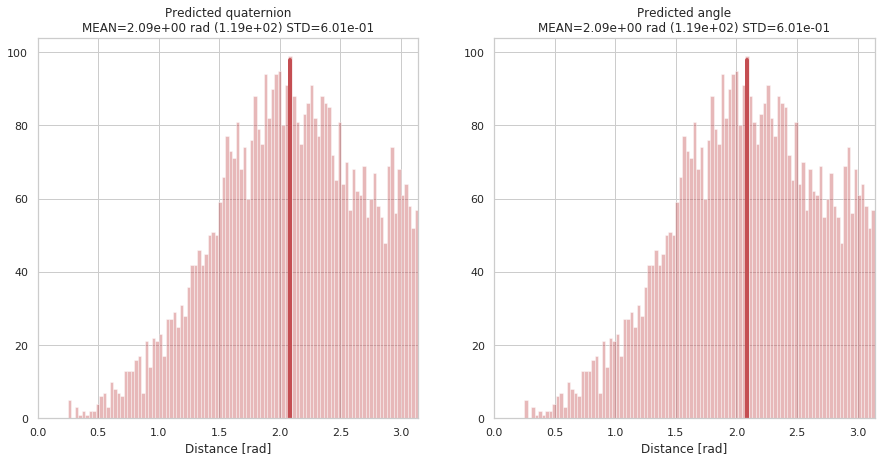

In [61]:
# check: both plots should be the same
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(quaternion2euler(qp)))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

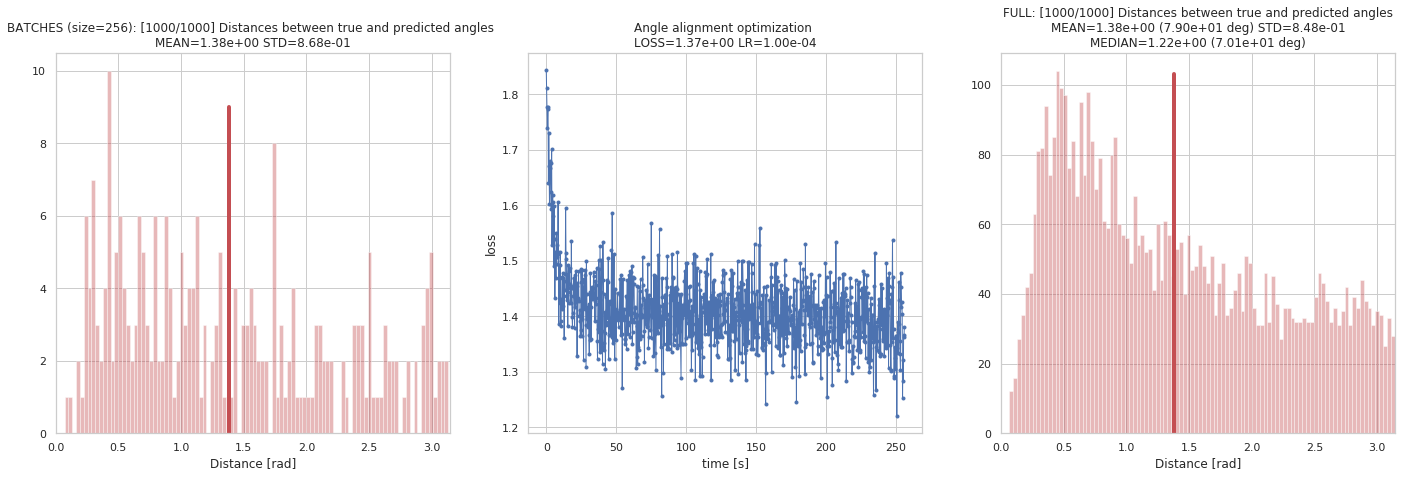

step 100/1000 (26s): loss = 1.50e+00
step 200/1000 (51s): loss = 1.42e+00
step 300/1000 (76s): loss = 1.41e+00
step 400/1000 (102s): loss = 1.41e+00
step 500/1000 (129s): loss = 1.40e+00
step 600/1000 (154s): loss = 1.40e+00
step 700/1000 (181s): loss = 1.39e+00
step 800/1000 (207s): loss = 1.39e+00
step 900/1000 (232s): loss = 1.40e+00
step 1000/1000 (258s): loss = 1.38e+00



In [64]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

In [65]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([ 0.2091954 ,  2.3375242 ,  5.65973506,  2.02671228, -0.20184263,
         2.40960386]),
 1.3772390153294511)

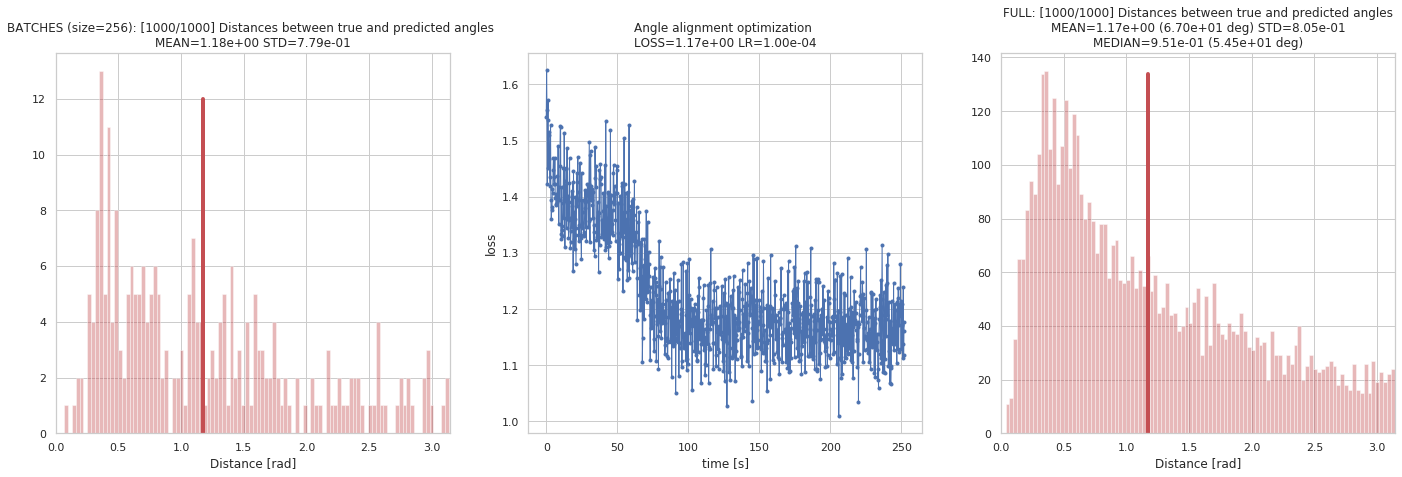

step 100/1000 (26s): loss = 1.41e+00
step 200/1000 (54s): loss = 1.38e+00
step 300/1000 (79s): loss = 1.30e+00
step 400/1000 (104s): loss = 1.18e+00
step 500/1000 (130s): loss = 1.17e+00
step 600/1000 (155s): loss = 1.18e+00
step 700/1000 (180s): loss = 1.17e+00
step 800/1000 (204s): loss = 1.17e+00
step 900/1000 (229s): loss = 1.17e+00
step 1000/1000 (254s): loss = 1.17e+00



In [66]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap,
                                             transposed=False)

---

## 2. Asymmetric Protein (5J0N)

Data used:
- Protein: 5j0n (asymmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

### 2.1. Experiments Summary - Losses w.r.t. Different Variance Values

Different variances are added to true values of `d_Q` distance. Performace of optimizations can be seen in the plots bellow:

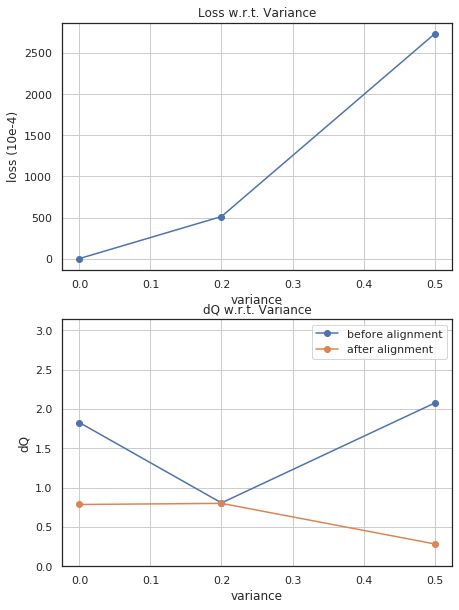

In [3]:
# losses
variances = [0.0, 0.2, 0.5]
losses = np.array([3.96e-04, 5.14e-02, 2.73e-01])
scale_degree = 4
losses = losses * 10**scale_degree

# d_Q before alignment
d_Q_before = np.array([1.827, 0.806, 2.075])

# d_Q after alignment
d_Q_after = np.array([0.786, 0.800, 0.285])


fig, ax = plt.subplots(2, 1, figsize=(7,10))
ax[0].plot(variances, losses, marker="o")
ax[0].set(xlabel='variance', ylabel=f'loss (10e{-scale_degree})', title='Loss w.r.t. Variance')
ax[0].grid()
ax[1].plot(variances, d_Q_before, marker="o", label='before alignment')
ax[1].set(xlabel='variance', ylabel='dQ', title='dQ w.r.t. Variance')
ax[1].plot(variances, d_Q_after, marker="o", label='after alignment')
ax[1].set_ylim((0, np.pi))
ax[1].grid()
ax[1].legend()

#fig.savefig("test.png")
plt.show()

---

### 2.2. Data Preparation

In [20]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [21]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [22]:
projections = data['Projections']

#### True Angles

In [23]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

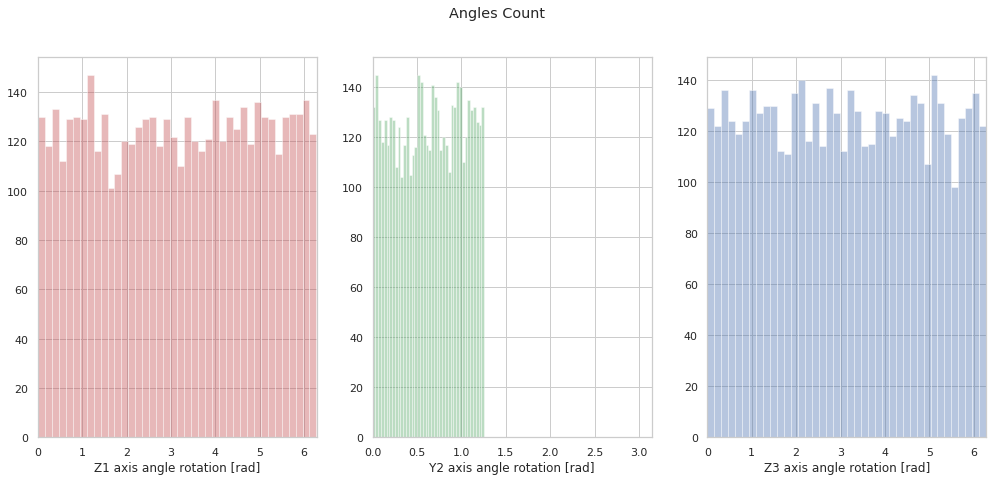

In [7]:
plot_angles_count(angles_true)

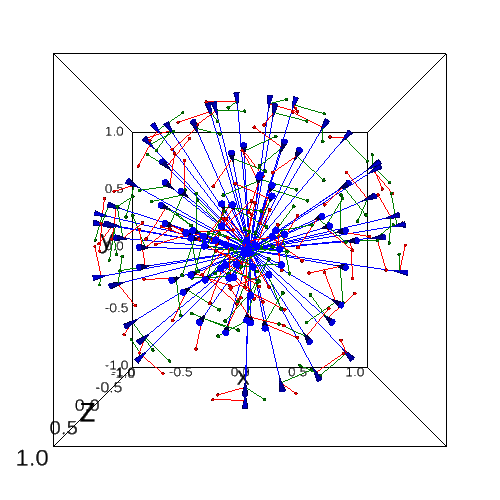

In [8]:
plot_rays(angles_true, indices=range(100))

In [9]:
display(ipv.screenshot())

Output()

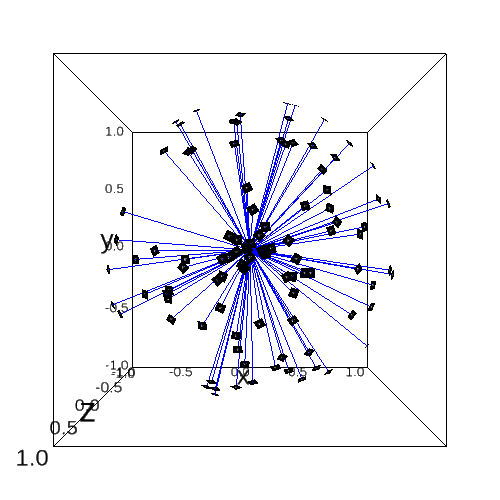

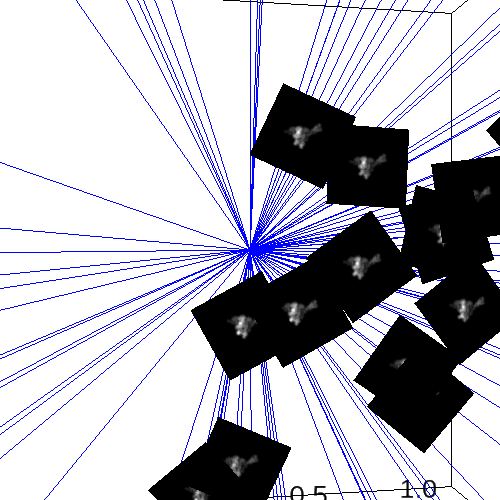

In [22]:
plot_images(angles_true, projections, indices=range(100), img_size_scale=0.05)

In [24]:
display(ipv.screenshot())

Output()

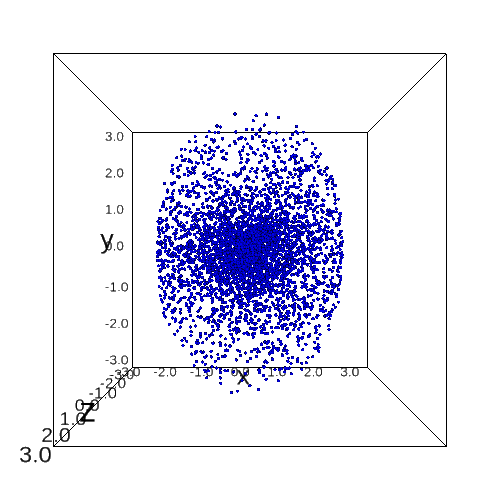

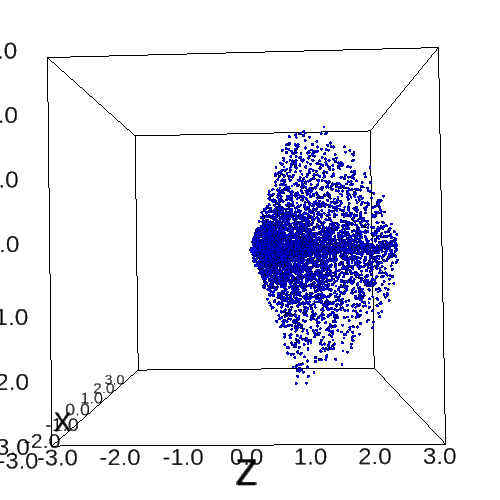

In [25]:
plot_angles_with_3rd_angle_magnitude(angles_true)

In [27]:
display(ipv.screenshot())

Output()

#### Predicted Angles

In [24]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [25]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

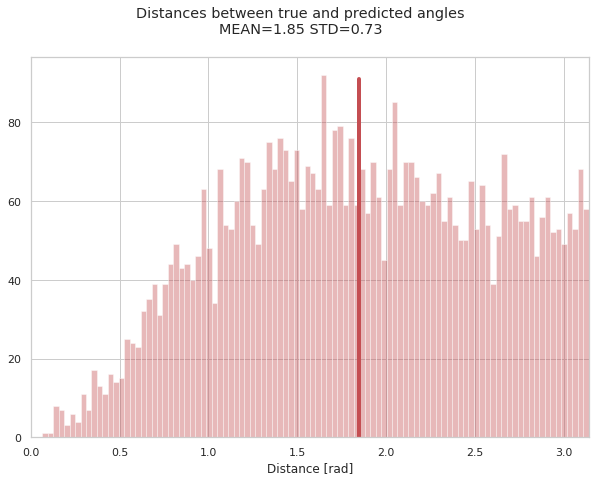

In [26]:
plot_distances_count(angles_predicted, angles_true)

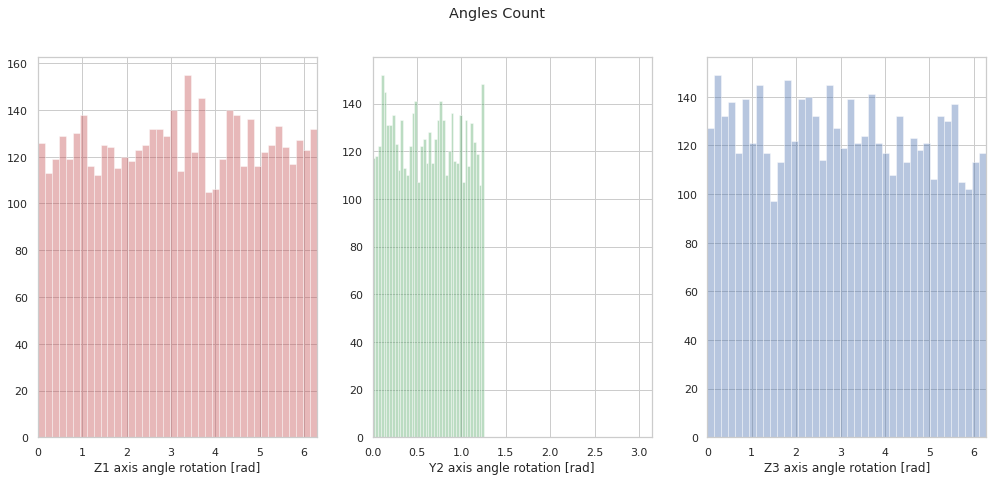

In [30]:
plot_angles_count(angles_predicted)

In [31]:
plot_euclidean_space(angles_predicted)

In [32]:
plot_euclidean_space(angles_true)

---

### 2.3. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [10]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [11]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [12]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

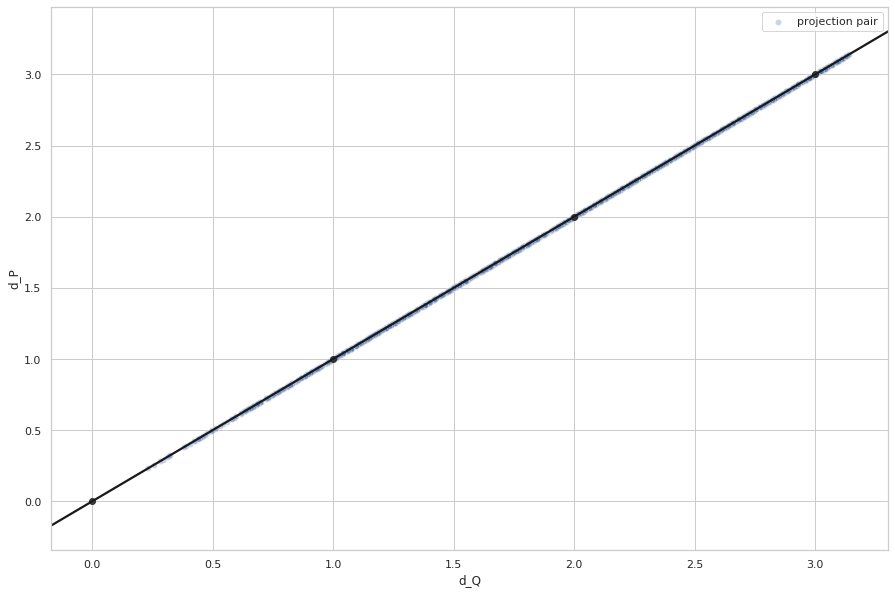

In [13]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

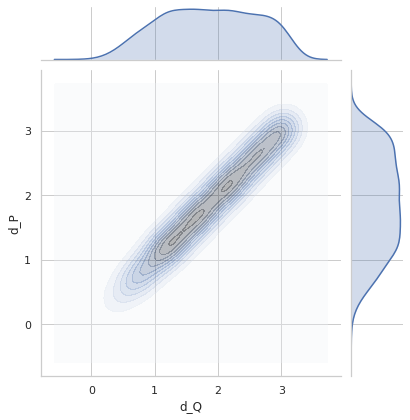

In [14]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

Perfect distances. Learning rate 0.01

step 15000/150000 (1833s): loss = 9.39e-02
step 30000/150000 (3621s): loss = 8.31e-02
step 45000/150000 (5454s): loss = 2.48e-02
step 60000/150000 (7256s): loss = 1.80e-03
step 75000/150000 (9061s): loss = 5.00e-04
step 90000/150000 (10850s): loss = 3.72e-04
step 105000/150000 (12638s): loss = 4.74e-04
step 120000/150000 (14524s): loss = 4.60e-04
step 135000/150000 (16384s): loss = 5.14e-04
step 150000/150000 (18282s): loss = 3.96e-04


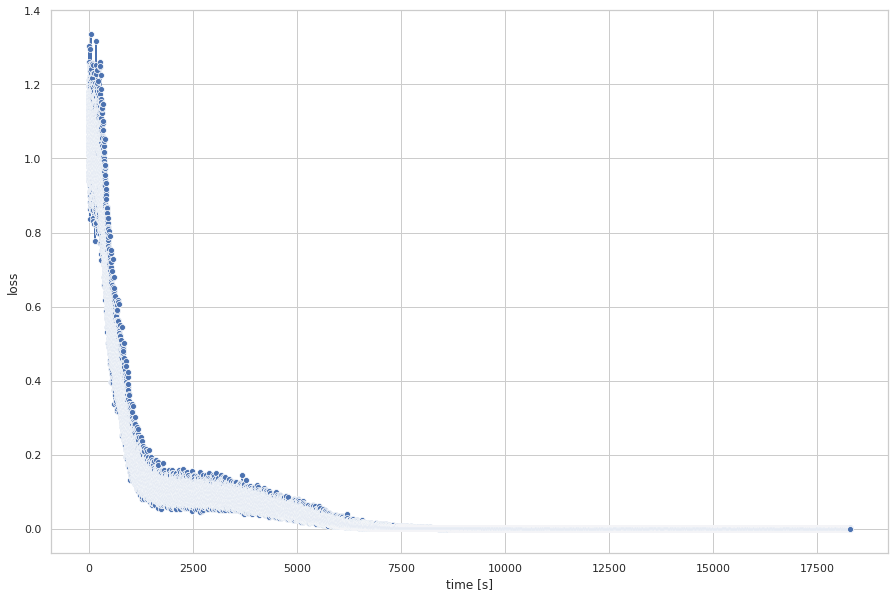

In [16]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [19]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("5j0n_predicted_angles.npy", ang_save)

In [20]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("5j0n_predicted_angles.npy")

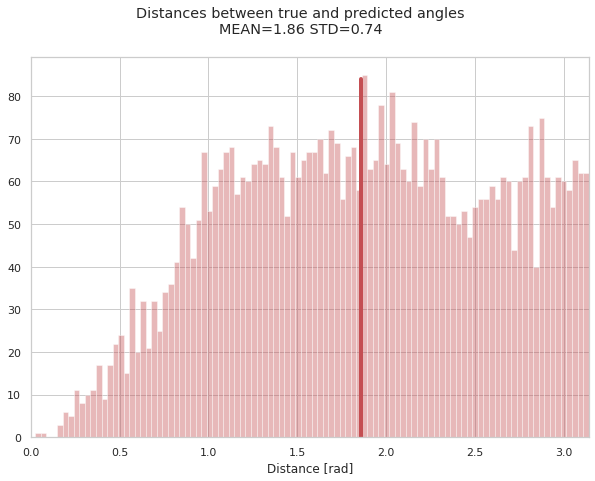

In [27]:
plot_distances_count(ap, angles_true)

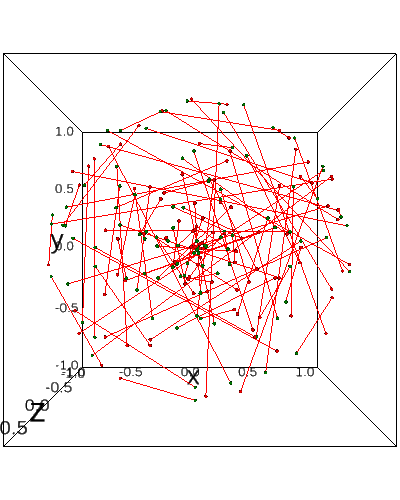

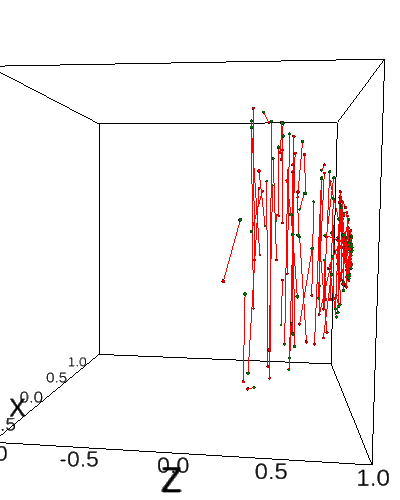

In [21]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [23]:
display(ipv.screenshot())

Output()

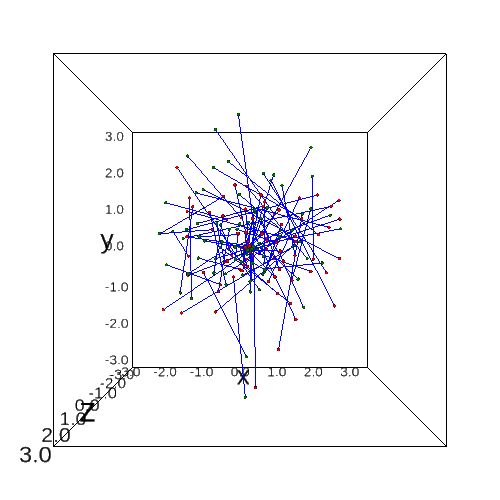

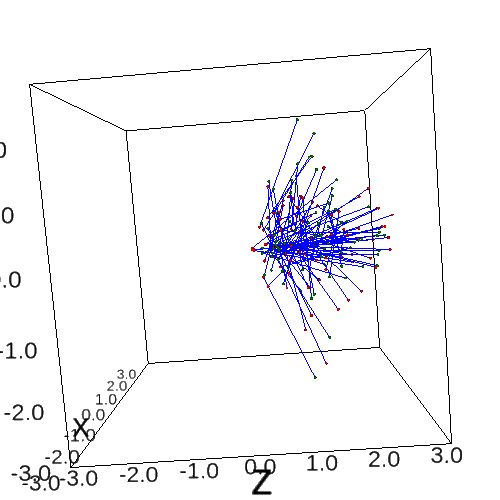

In [24]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [26]:
display(ipv.screenshot())

Output()

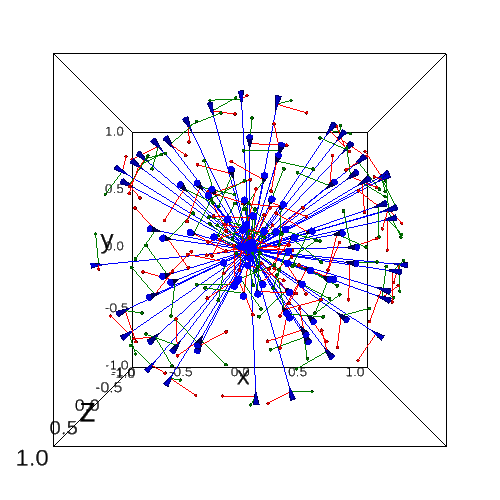

In [27]:
plot_rays(ap, indices=range(100))

In [28]:
display(ipv.screenshot())

Output()

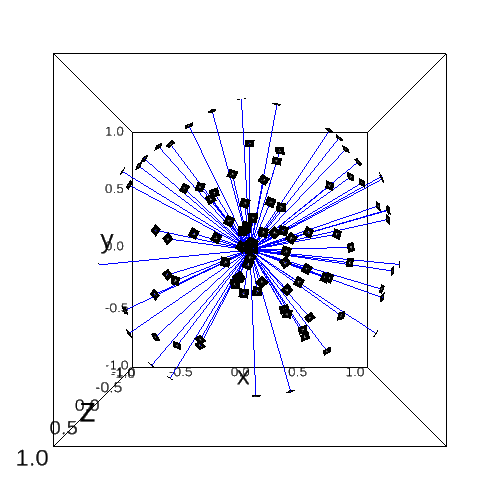

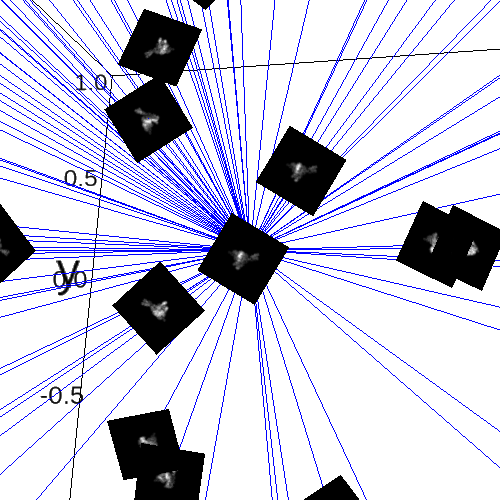

In [29]:
plot_images(ap, projections, indices=range(100),img_size_scale=0.05)

In [31]:
display(ipv.screenshot())

Output()

#### Angles' Alignment

In [37]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [38]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7128134720322381
Geodesic distance:  0.7740014290010898  rad ( 44.34701521885708  degrees)
Quaternion distance:  1.8270133311219365


(0.7128134720322381, 0.7740014290010898, 1.8270133311219365)

FLIPPING: (1, 1, 1)
step 100/1000 (10s): loss = 1.83e+00
step 200/1000 (19s): loss = 1.92e+00
step 300/1000 (29s): loss = 1.76e+00
step 400/1000 (38s): loss = 1.82e+00
step 500/1000 (48s): loss = 1.80e+00
step 600/1000 (57s): loss = 1.72e+00
step 700/1000 (67s): loss = 1.84e+00
step 800/1000 (76s): loss = 1.75e+00
step 900/1000 (86s): loss = 1.76e+00
step 1000/1000 (96s): loss = 1.85e+00
Rotation: [-0.85426502 -0.00420539 -0.87452053];  Loss: 1.8539374676213487
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.80e+00
step 200/1000 (19s): loss = 1.82e+00
step 300/1000 (30s): loss = 1.88e+00
step 400/1000 (39s): loss = 1.80e+00
step 500/1000 (49s): loss = 1.85e+00
step 600/1000 (58s): loss = 1.75e+00
step 700/1000 (68s): loss = 1.83e+00
step 800/1000 (77s): loss = 1.76e+00
step 900/1000 (87s): loss = 1.86e+00
step 1000/1000 (97s): loss = 1.87e+00
Rotation: [ 0.22006837 -0.00704033  0.23911573];  Loss: 1.867599111990661
FLIPPING: (1, -1, 1)
step 100/1000 (10s): loss = 1.86e+00
step 200/1

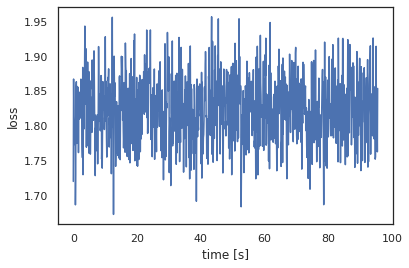

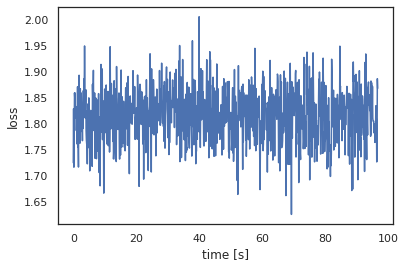

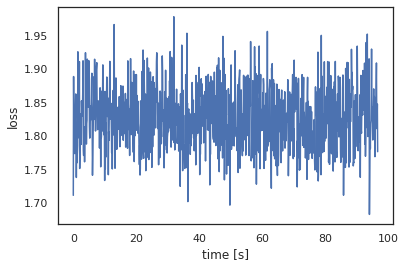

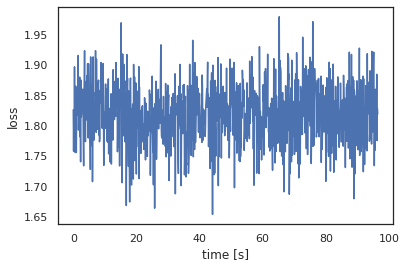

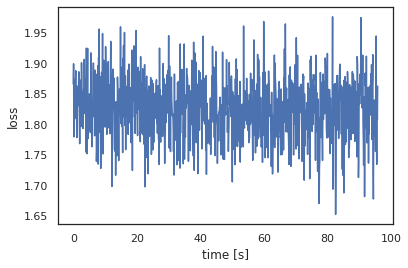

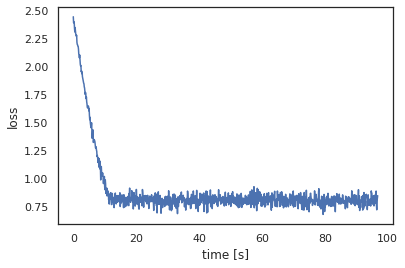

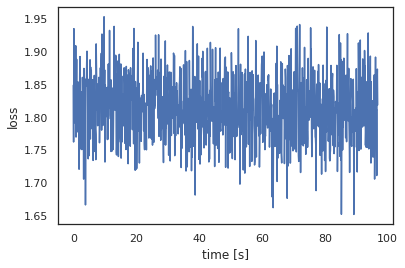

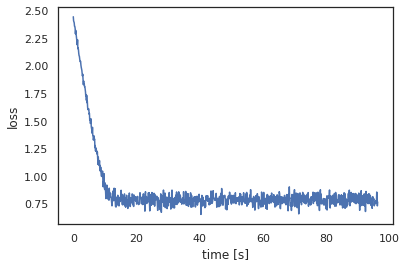

In [39]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [40]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.17304862,  0.00356662, -1.17243231])>],
 0.7665804240592266)

In [41]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [42]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.6937805937542387
Geodesic distance:  0.7520183462892541  rad ( 43.087477358781896  degrees)
Quaternion distance:  0.7863202591820717


(0.6937805937542387, 0.7520183462892541, 0.7863202591820717)

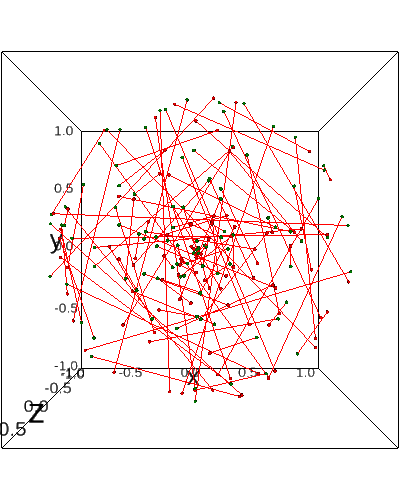

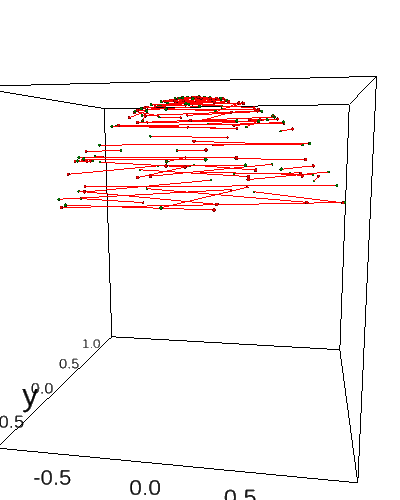

In [43]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [45]:
display(ipv.screenshot())

Output()

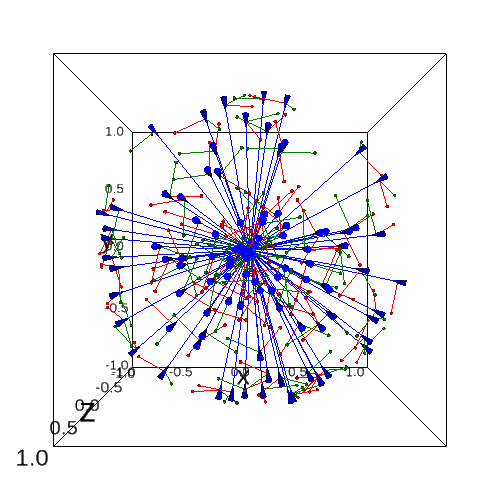

In [46]:
plot_rays(angles_predicted_new, range(100))

In [47]:
display(ipv.screenshot())

Output()

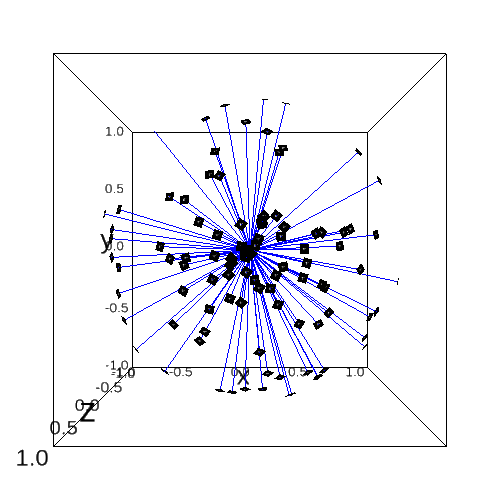

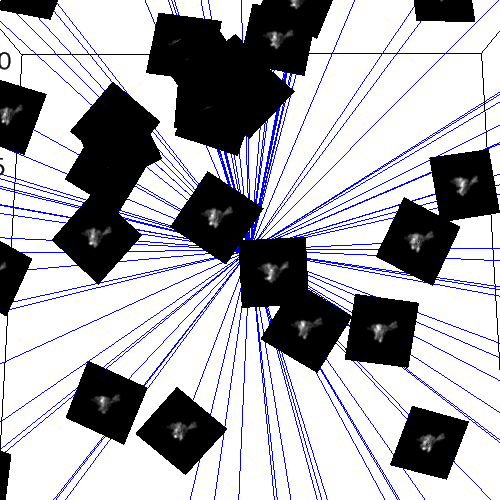

In [48]:
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [50]:
display(ipv.screenshot())

Output()

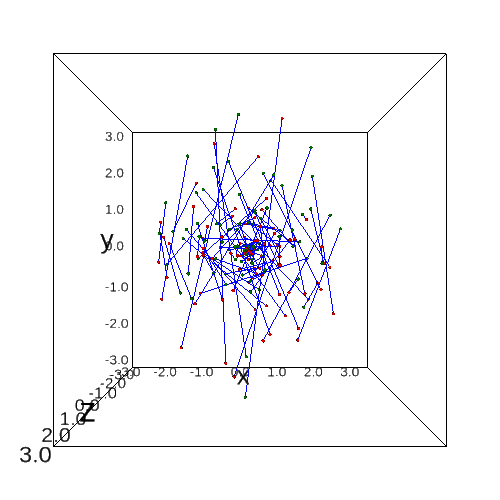

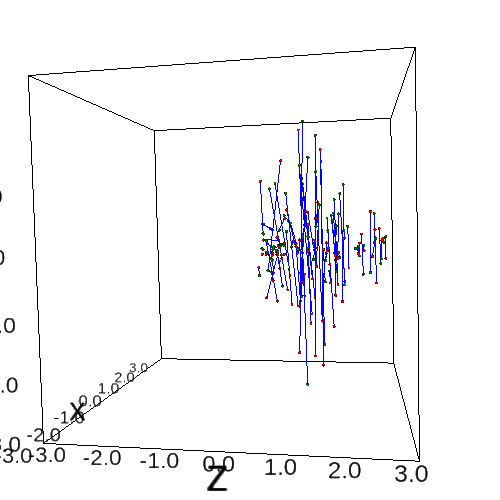

In [51]:
plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [53]:
display(ipv.screenshot())

Output()

---

### 2.4. Angle Recovery: Variance 0.0

#### dP/dQ plot

In [13]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [14]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.0, dtype=tf.float64)
    return norm_distr  

In [15]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)#.T[0]
dQ_values = d_q(q1_true, q2_true)#.numpy()

<Figure size 432x288 with 0 Axes>

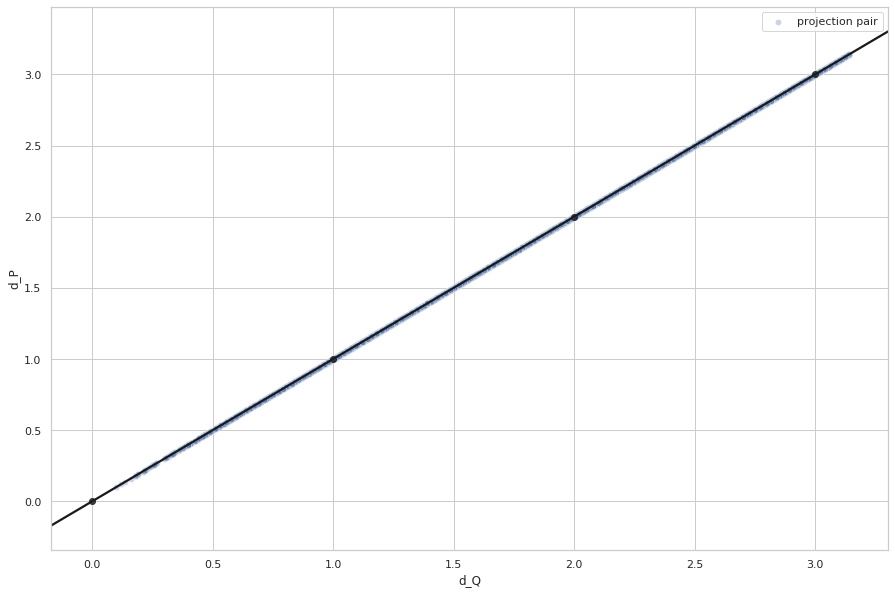

In [16]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

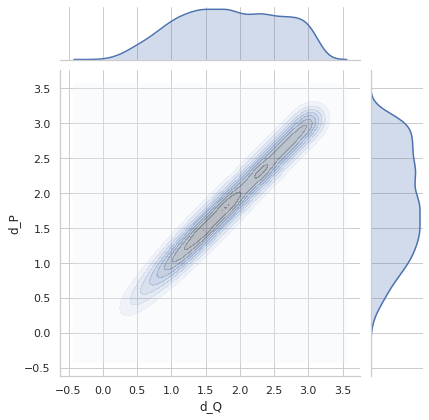

In [17]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [ ]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 15000/150000 (1951s): loss = 9.32e-02
step 30000/150000 (3819s): loss = 9.04e-02
step 45000/150000 (5648s): loss = 5.19e-02
step 60000/150000 (7496s): loss = 3.52e-02
step 75000/150000 (9361s): loss = 4.28e-03
step 90000/150000 (11172s): loss = 6.86e-04
step 105000/150000 (13033s): loss = 3.99e-04


In [ ]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.npy", ang_save)

In [29]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/5j0n_predicted_angles_var0.npy")

In [ ]:
plot_distances_count(ap, angles_true)

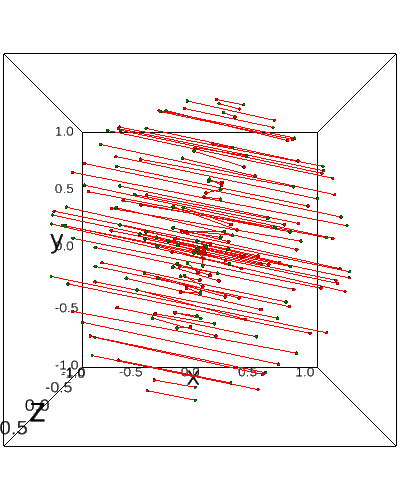

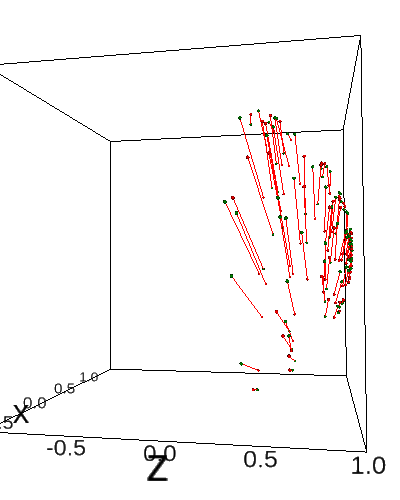

In [20]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [22]:
display(ipv.screenshot())

Output()

### Angle Alignment

In [24]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [25]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7126255098249455
Geodesic distance:  0.7738962755045573  rad ( 44.34099036730473  degrees)
Quaternion distance:  1.804002719050027


(0.7126255098249455, 0.7738962755045573, 1.804002719050027)

FLIPPING: (1, 1, 1)
step 500/5000 (47s): loss = 1.81e+00
step 1000/5000 (94s): loss = 1.82e+00
step 1500/5000 (140s): loss = 1.79e+00
step 2000/5000 (187s): loss = 1.82e+00
step 2500/5000 (234s): loss = 1.74e+00
step 3000/5000 (281s): loss = 1.85e+00
step 3500/5000 (327s): loss = 1.78e+00
step 4000/5000 (374s): loss = 1.77e+00
step 4500/5000 (420s): loss = 1.80e+00
step 5000/5000 (467s): loss = 1.86e+00
Rotation: [5.65906161e-01 1.38507948e-05 5.71285007e-01];  Loss: 1.860901035947026
FLIPPING: (1, 1, -1)
step 500/5000 (47s): loss = 1.60e+00
step 1000/5000 (93s): loss = 1.54e+00
step 1500/5000 (141s): loss = 1.61e+00
step 2000/5000 (188s): loss = 1.57e+00
step 2500/5000 (234s): loss = 1.52e+00
step 3000/5000 (281s): loss = 1.59e+00
step 3500/5000 (329s): loss = 1.53e+00
step 4000/5000 (376s): loss = 1.48e+00
step 4500/5000 (422s): loss = 1.54e+00
step 5000/5000 (470s): loss = 1.66e+00
Rotation: [-1.37570889 -0.00482575 -1.34775901];  Loss: 1.6630476512434507
FLIPPING: (1, -1, 1)
step 5

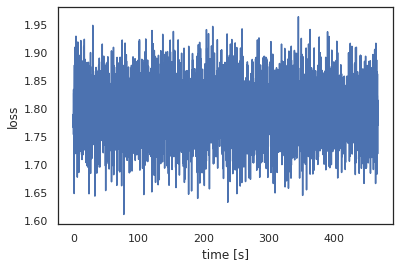

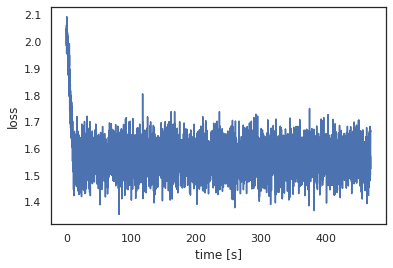

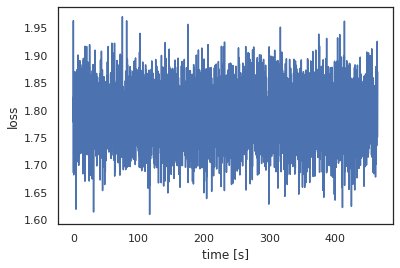

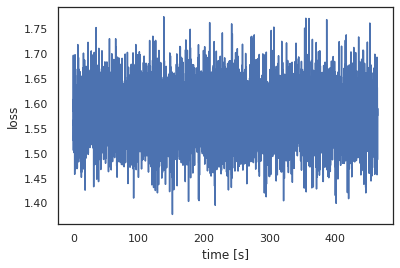

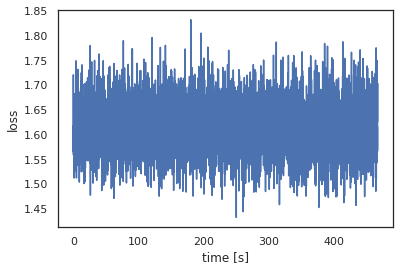

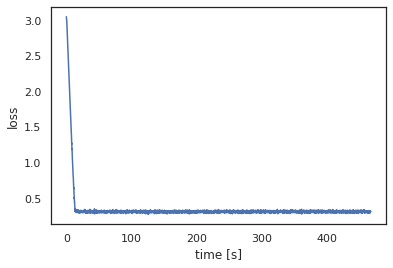

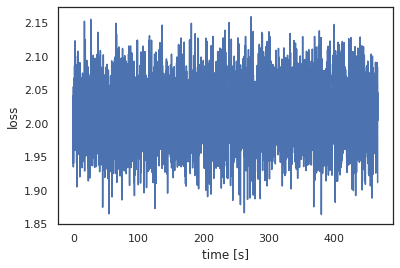

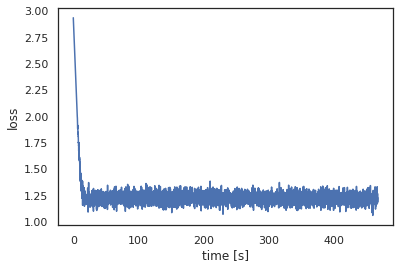

In [26]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [27]:
flips, a_R, loss

((-1, 1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.50157382, 0.02016914, 1.58842314])>],
 0.31754020187752174)

In [28]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [29]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.2530815542505399
Geodesic distance:  0.254271104790386  rad ( 14.568661156617807  degrees)
Quaternion distance:  0.3125839033835222


(0.2530815542505399, 0.254271104790386, 0.3125839033835222)

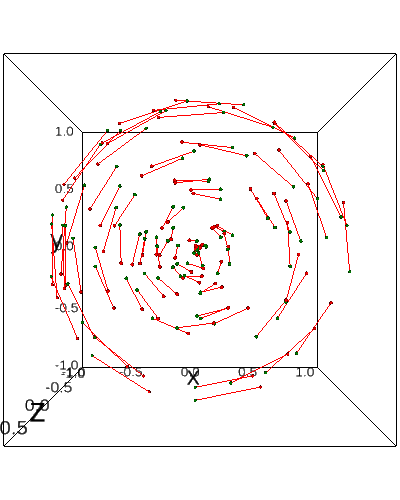

In [30]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [31]:
display(ipv.screenshot())

Output()

---

### 2.5. Angle Recovery: Variance 0.2

#### dP/dQ plot

In [9]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.2, dtype=tf.float64)
    return norm_distr  

In [10]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

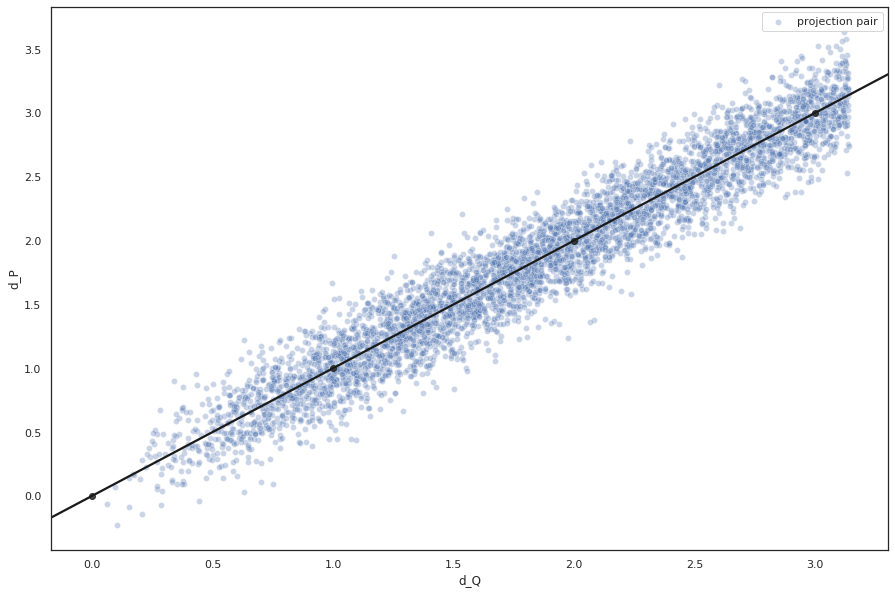

In [11]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

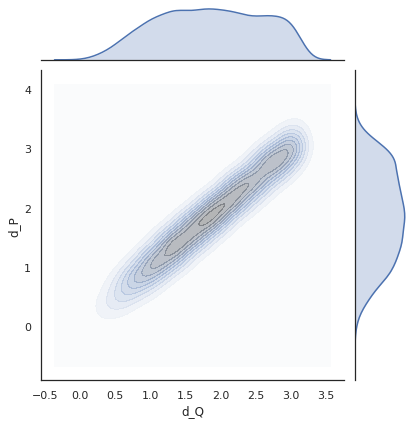

In [12]:
plot_dP_dQ_density(dP_values, dQ_values)

In [13]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.20069358422911474

#### Angle Recovery

In [16]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1900s): loss = 1.15e-01
step 30000/150000 (3690s): loss = 1.14e-01
step 45000/150000 (5592s): loss = 5.95e-02
step 60000/150000 (7429s): loss = 4.56e-02
step 75000/150000 (9313s): loss = 4.66e-02
step 90000/150000 (11124s): loss = 4.63e-02
step 105000/150000 (12911s): loss = 4.67e-02
step 120000/150000 (14726s): loss = 4.31e-02
step 135000/150000 (16566s): loss = 4.21e-02
step 150000/150000 (18395s): loss = 5.14e-02


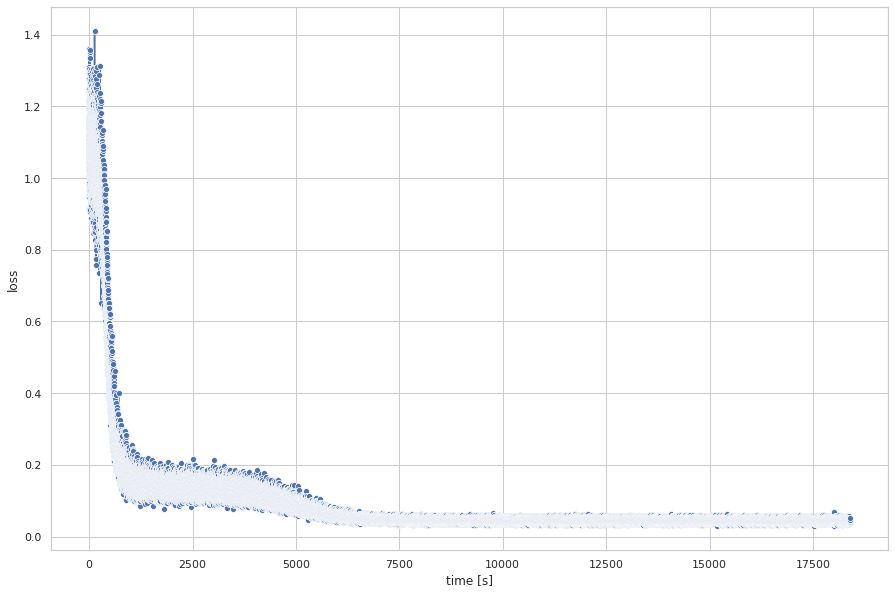

In [17]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [18]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.2.npy", ang_save)

In [47]:
ap = np.load("data/5j0n_predicted_angles_var0.2.npy")

In [11]:
plot_euclidean_space(ap)

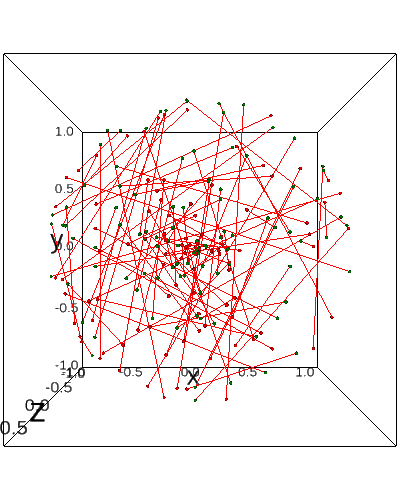

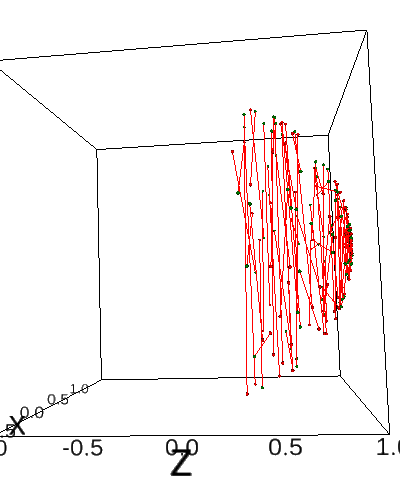

In [12]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [14]:
display(ipv.screenshot())

Output()

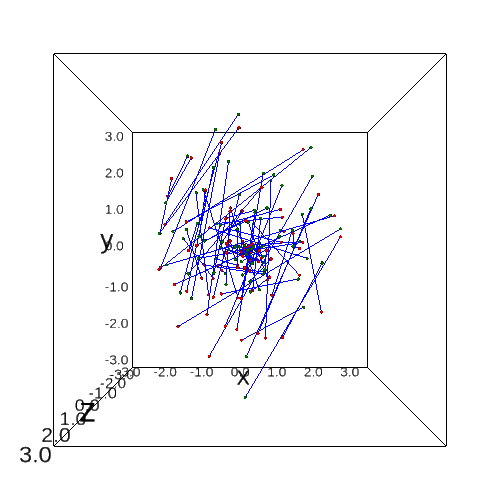

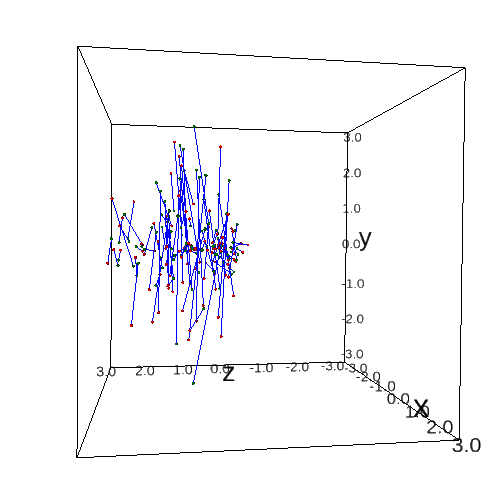

In [17]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [19]:
display(ipv.screenshot())

Output()

#### Angles' Alignment

In [15]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [16]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7039827178594478
Geodesic distance:  0.7632859162415673  rad ( 43.73306156241786  degrees)
Quaternion distance:  0.8065012186478349


(0.7039827178594478, 0.7632859162415673, 0.8065012186478349)

FLIPPING: (1, 1, 1)
step 100/1000 (9s): loss = 7.29e-01
step 200/1000 (19s): loss = 7.96e-01
step 300/1000 (28s): loss = 7.81e-01
step 400/1000 (38s): loss = 8.20e-01
step 500/1000 (47s): loss = 7.86e-01
step 600/1000 (56s): loss = 8.43e-01
step 700/1000 (66s): loss = 8.01e-01
step 800/1000 (75s): loss = 7.75e-01
step 900/1000 (85s): loss = 7.47e-01
step 1000/1000 (94s): loss = 8.16e-01
Rotation: [-0.03496581  0.00395882 -0.0277902 ];  Loss: 0.8162119941909995
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.87e+00
step 200/1000 (20s): loss = 1.82e+00
step 300/1000 (30s): loss = 1.73e+00
step 400/1000 (40s): loss = 1.76e+00
step 500/1000 (50s): loss = 1.82e+00
step 600/1000 (60s): loss = 1.91e+00
step 700/1000 (69s): loss = 1.80e+00
step 800/1000 (78s): loss = 1.78e+00
step 900/1000 (88s): loss = 1.81e+00
step 1000/1000 (97s): loss = 1.81e+00
Rotation: [-1.37299657  0.05917804 -1.35007814];  Loss: 1.80948920253194
FLIPPING: (1, -1, 1)
step 100/1000 (10s): loss = 8.60e-01
step 200/100

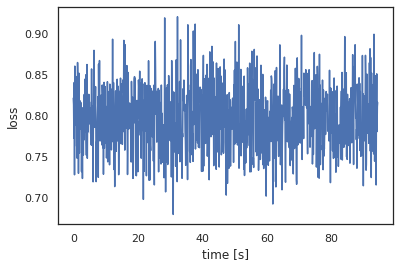

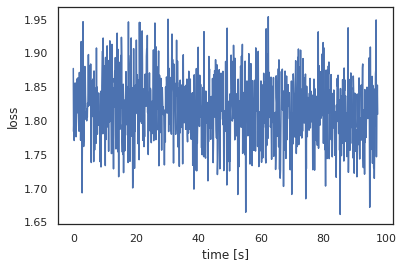

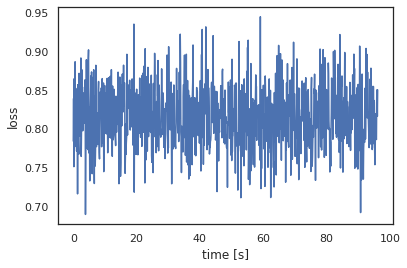

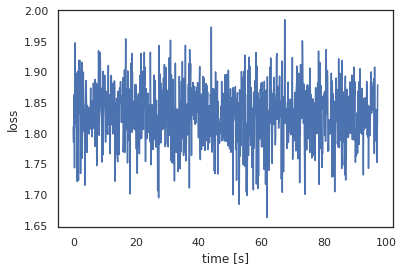

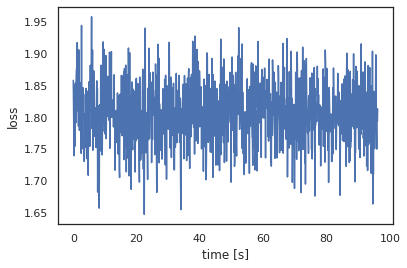

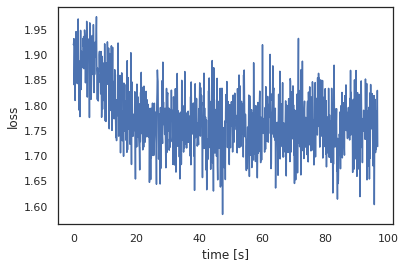

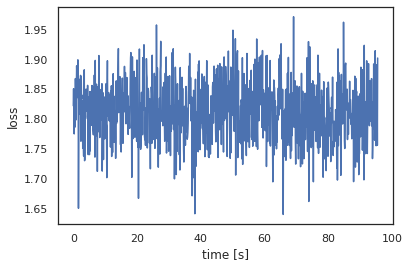

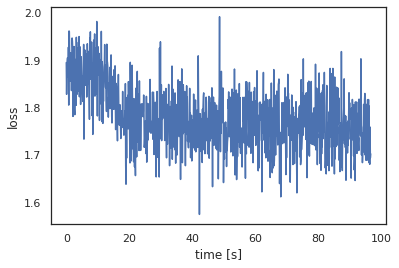

In [17]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [18]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-0.03496581,  0.00395882, -0.0277902 ])>],
 0.8162119941909995)

In [19]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [20]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.7031941968315075
Geodesic distance:  0.7624277205887539  rad ( 43.68389057351518  degrees)
Quaternion distance:  0.8001937093120989


(0.7031941968315075, 0.7624277205887539, 0.8001937093120989)

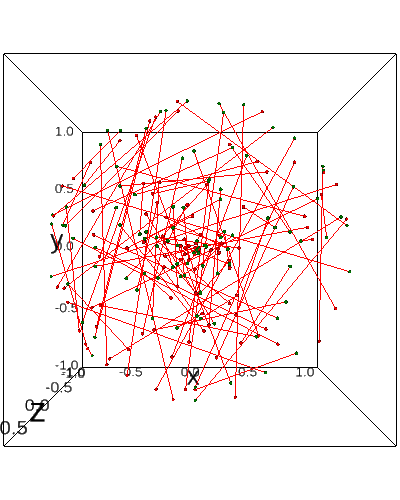

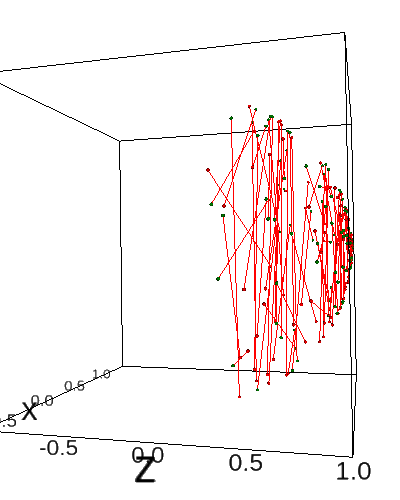

In [21]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [23]:
display(ipv.screenshot())

Output()

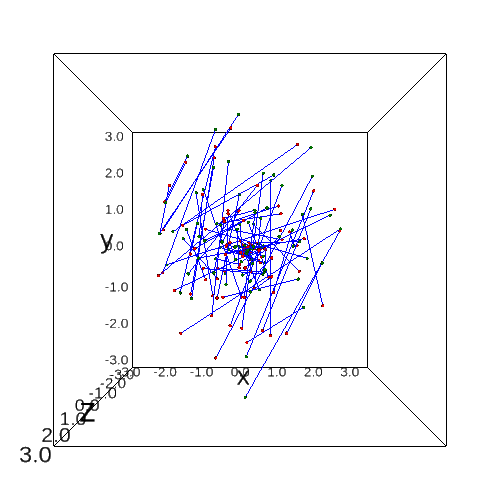

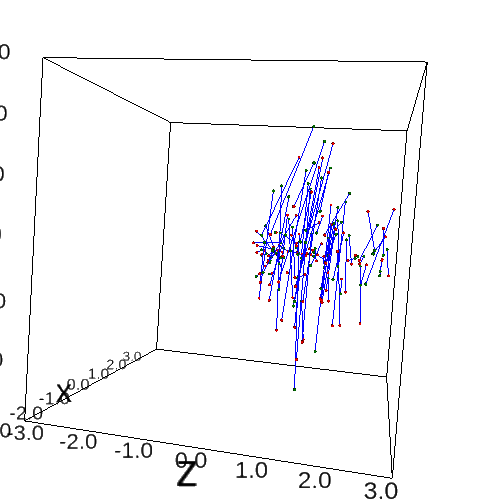

In [24]:
plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [26]:
display(ipv.screenshot())

Output()

---

### 1.6. Angle Recovery: Variance 0.5

#### dP/dQ plot

In [27]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.5, dtype=tf.float64)
    return norm_distr  

In [28]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

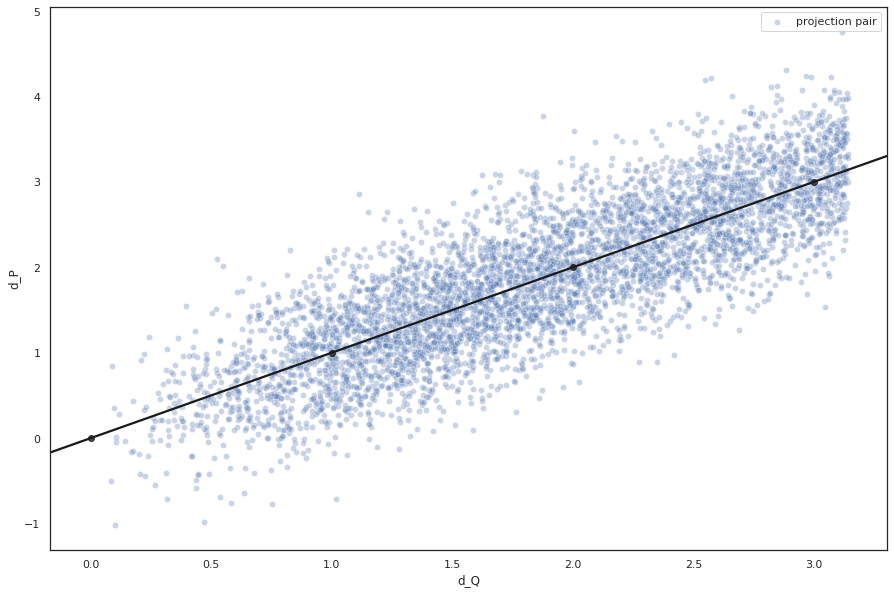

In [29]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

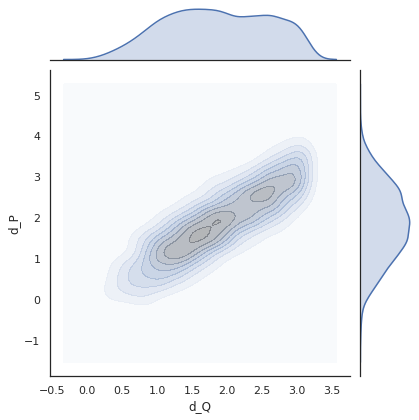

In [30]:
plot_dP_dQ_density(dP_values, dQ_values)

In [46]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.49672542297015565

#### Angle Recovery

In [31]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1847s): loss = 3.65e-01
step 45000/150000 (5348s): loss = 4.14e-01
step 60000/150000 (7175s): loss = 3.30e-01
step 75000/150000 (8987s): loss = 3.10e-01
step 90000/150000 (10788s): loss = 2.91e-01
step 105000/150000 (12589s): loss = 3.00e-01
step 120000/150000 (14423s): loss = 2.87e-01
step 135000/150000 (16176s): loss = 2.51e-01
step 150000/150000 (17917s): loss = 2.73e-01


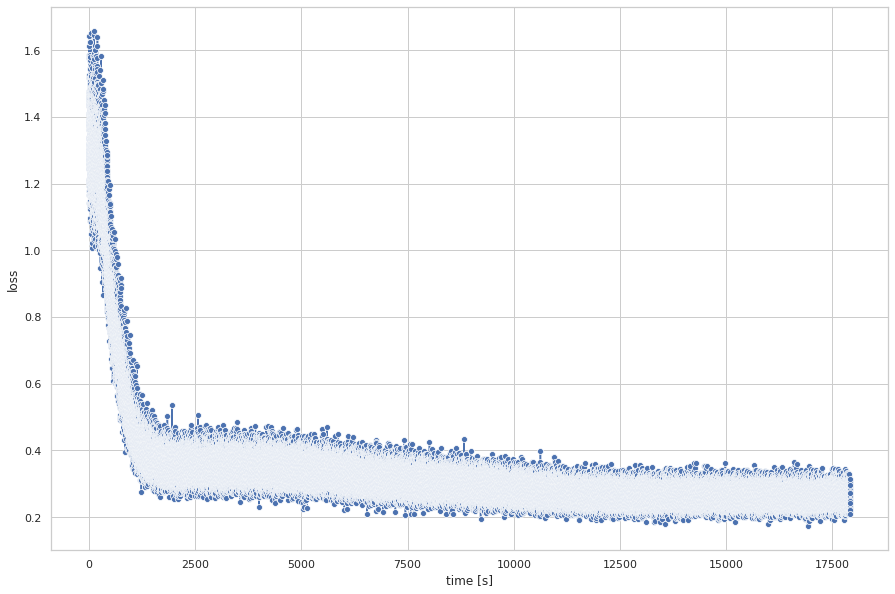

In [32]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [33]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.5.npy", ang_save)

In [48]:
ap = np.load("data/5j0n_predicted_angles_var0.5.npy")

In [13]:
plot_euclidean_space(ap)

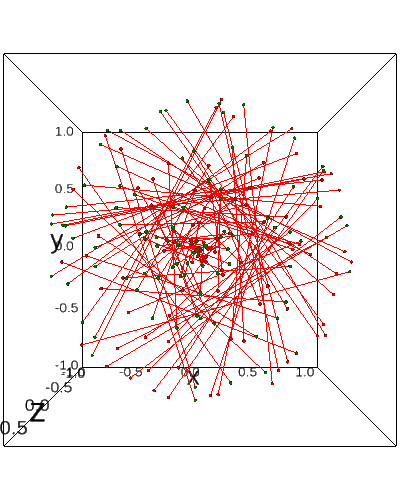

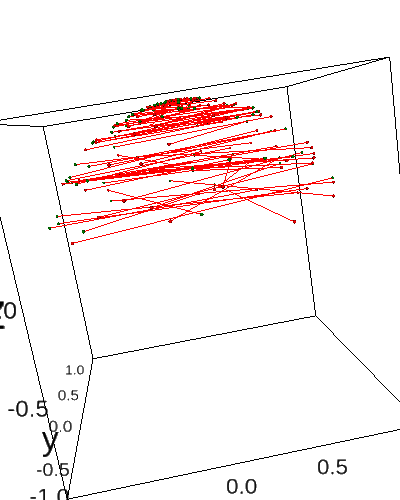

In [35]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [37]:
display(ipv.screenshot())

Output()

#### Angle Alignment

In [39]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

In [40]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  1.0177718342919242
Geodesic distance:  1.133184537632365  rad ( 64.92669141581813  degrees)
Quaternion distance:  2.075320937960786


(1.0177718342919242, 1.133184537632365, 2.075320937960786)

FLIPPING: (1, 1, 1)
step 100/1000 (10s): loss = 3.22e-01
step 200/1000 (19s): loss = 2.91e-01
step 300/1000 (29s): loss = 2.97e-01
step 400/1000 (38s): loss = 2.80e-01
step 500/1000 (48s): loss = 2.89e-01
step 600/1000 (57s): loss = 2.92e-01
step 700/1000 (67s): loss = 2.78e-01
step 800/1000 (77s): loss = 2.87e-01
step 900/1000 (86s): loss = 2.82e-01
step 1000/1000 (96s): loss = 2.77e-01
Rotation: [-1.01961593 -0.01429466 -1.01992495];  Loss: 0.27693228080045174
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.61e+00
step 200/1000 (20s): loss = 1.63e+00
step 300/1000 (29s): loss = 1.62e+00
step 400/1000 (39s): loss = 1.54e+00
step 500/1000 (48s): loss = 1.67e+00
step 600/1000 (58s): loss = 1.50e+00
step 700/1000 (67s): loss = 1.61e+00
step 800/1000 (77s): loss = 1.59e+00
step 900/1000 (86s): loss = 1.63e+00
step 1000/1000 (96s): loss = 1.69e+00
Rotation: [1.24233443 0.00987119 1.24260107];  Loss: 1.6885201429963965
FLIPPING: (1, -1, 1)
step 100/1000 (9s): loss = 1.24e+00
step 200/100

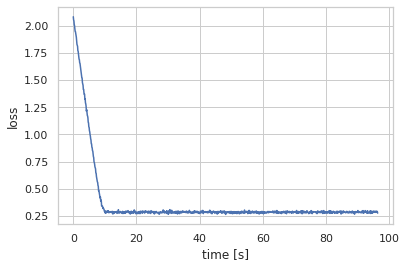

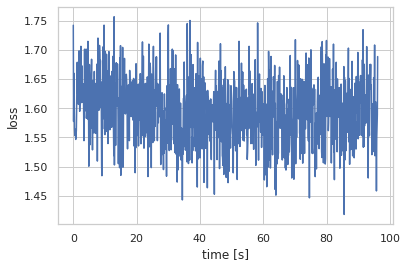

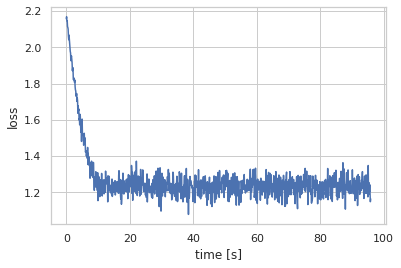

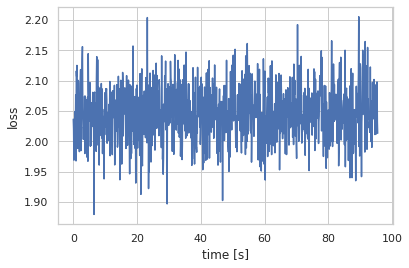

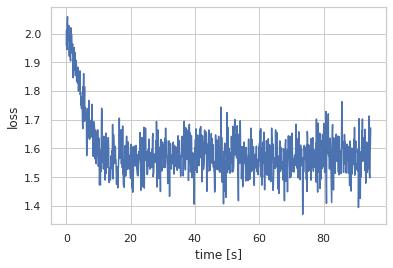

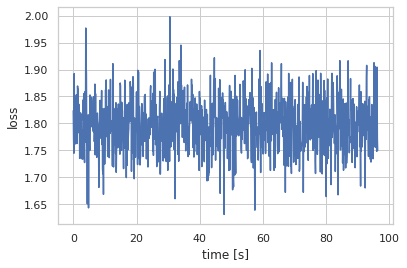

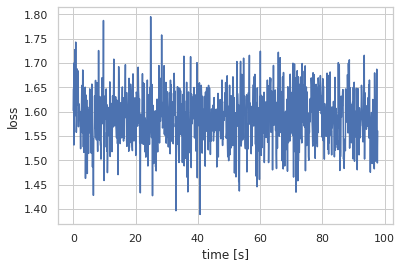

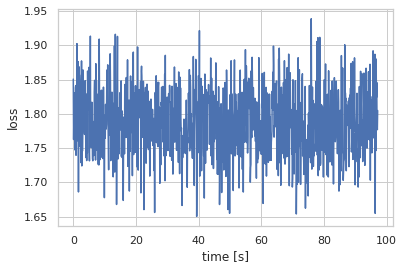

In [41]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [42]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.01961593, -0.01429466, -1.01992495])>],
 0.27693228080045174)

In [43]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [44]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.21848139163955166
Geodesic distance:  0.2191668939083681  rad ( 12.557338029940965  degrees)
Quaternion distance:  0.2856773364952681


(0.21848139163955166, 0.2191668939083681, 0.2856773364952681)

In [45]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [34]:
display(ipv.screenshot())

Output()

---

### 1.7. Angle Recovery: Variance 0.8

#### dP/dQ plot

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

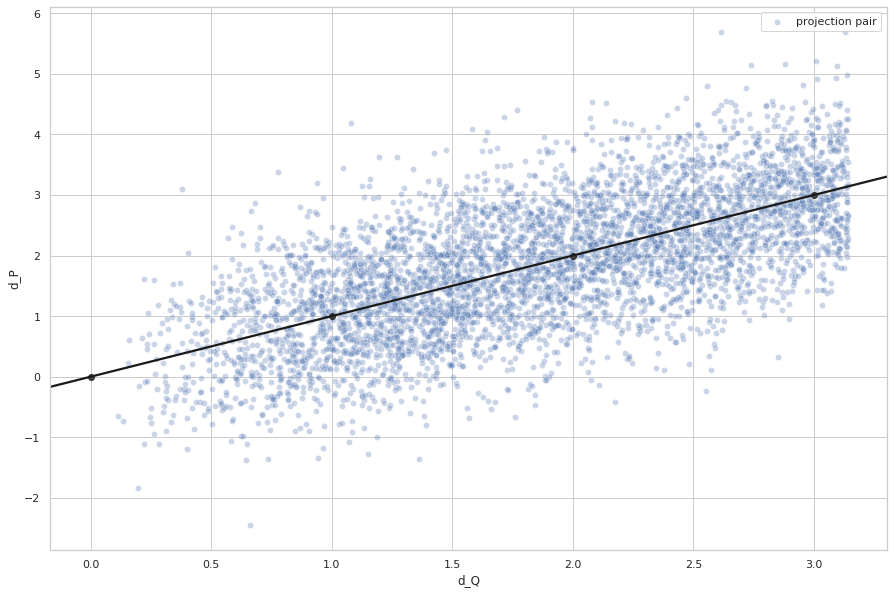

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

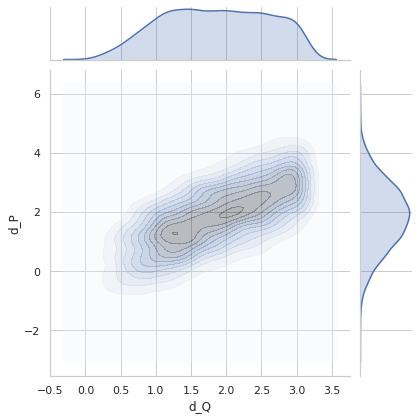

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1377s): loss = 7.84e-01
step 30000/150000 (2800s): loss = 6.97e-01
step 45000/150000 (4231s): loss = 6.67e-01
step 60000/150000 (5712s): loss = 6.87e-01
step 75000/150000 (7162s): loss = 7.59e-01
step 90000/150000 (8665s): loss = 6.65e-01
step 105000/150000 (10180s): loss = 7.26e-01
step 120000/150000 (11723s): loss = 6.59e-01
step 135000/150000 (13170s): loss = 7.20e-01
step 150000/150000 (14638s): loss = 6.32e-01


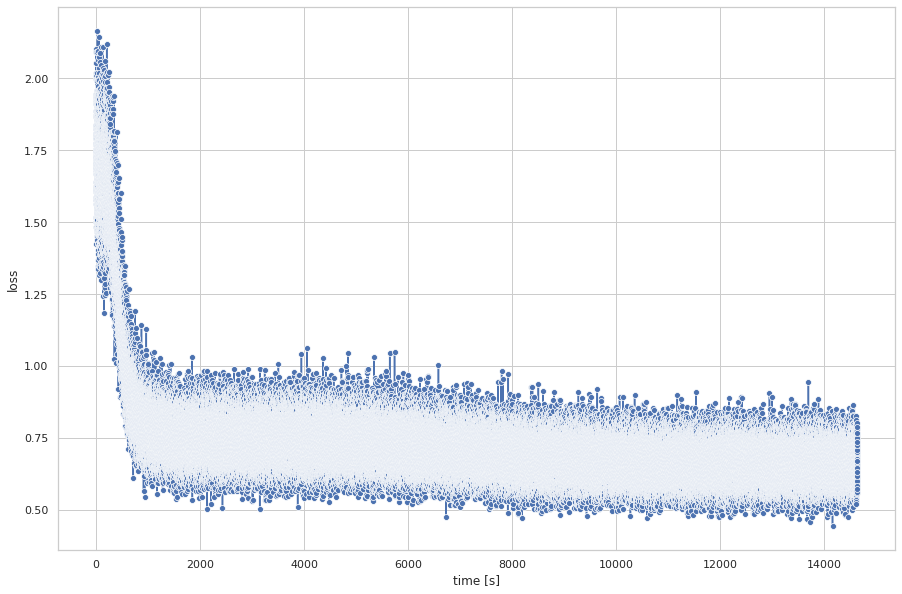

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [23]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.8.npy", ang_save)

In [24]:
ap = np.load("data/5j0n_predicted_angles_var0.8.npy")

In [25]:
plot_euclidean_space(ap)

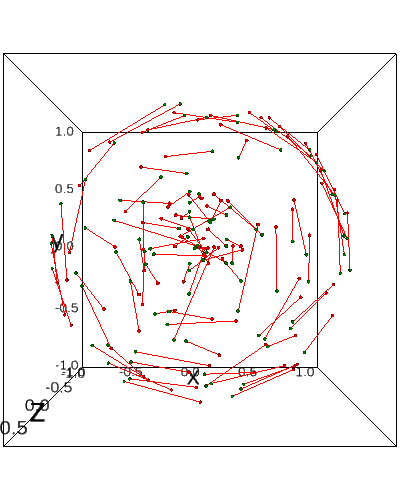

In [26]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [27]:
display(ipv.screenshot())

Output()

#### Angle Alignment

In [28]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

In [29]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.29311857540805325
Geodesic distance:  0.29482953242402793  rad ( 16.89248788371226  degrees)
Quaternion distance:  0.4303240739610892


(0.29311857540805325, 0.29482953242402793, 0.4303240739610892)

FLIPPING: (1, 1, 1)
step 100/1000 (6s): loss = 1.65e-01
step 200/1000 (13s): loss = 1.66e-01
step 300/1000 (20s): loss = 1.76e-01
step 400/1000 (26s): loss = 1.72e-01
step 500/1000 (33s): loss = 1.68e-01
step 600/1000 (40s): loss = 1.68e-01
step 700/1000 (46s): loss = 1.65e-01
step 800/1000 (53s): loss = 1.68e-01
step 900/1000 (59s): loss = 1.76e-01
step 1000/1000 (66s): loss = 1.75e-01
Rotation: [0.17098438 0.01317988 0.22689199];  Loss: 0.17521755508496734
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.53e+00
step 200/1000 (13s): loss = 1.54e+00
step 300/1000 (20s): loss = 1.63e+00
step 400/1000 (27s): loss = 1.54e+00
step 500/1000 (34s): loss = 1.57e+00
step 600/1000 (40s): loss = 1.62e+00
step 700/1000 (47s): loss = 1.54e+00
step 800/1000 (54s): loss = 1.51e+00
step 900/1000 (60s): loss = 1.43e+00
step 1000/1000 (67s): loss = 1.53e+00
Rotation: [-1.16161379 -0.00471375 -1.16927731];  Loss: 1.5271332334188548
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 1.29e+00
step 200/1000 

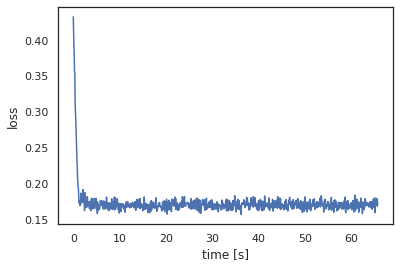

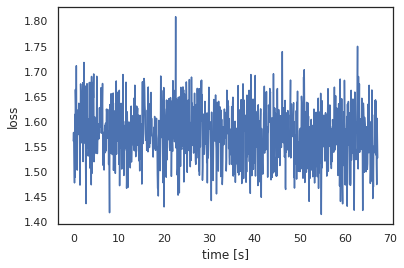

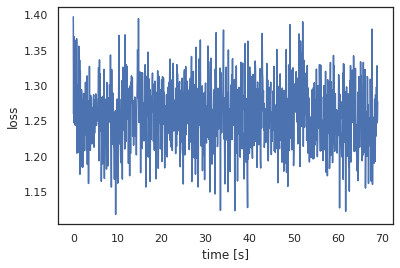

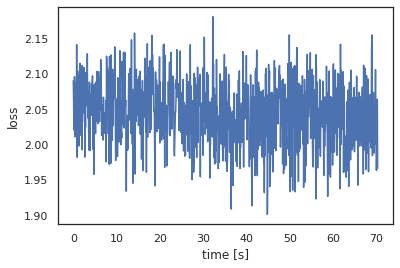

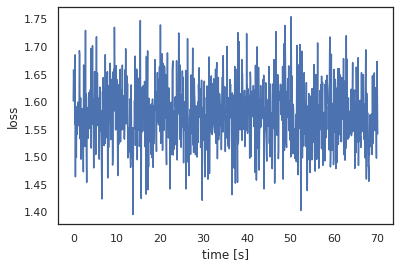

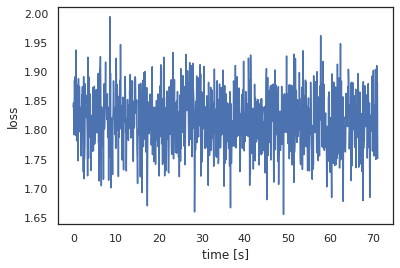

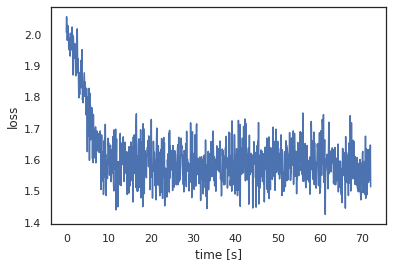

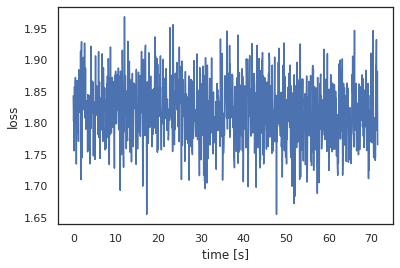

In [30]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [31]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.17098438, 0.01317988, 0.22689199])>],
 0.17521755508496734)

In [32]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [33]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.12973866189875452
Geodesic distance:  0.12994516828095914  rad ( 7.445309710616214  degrees)
Quaternion distance:  0.17043514391360612


(0.12973866189875452, 0.12994516828095914, 0.17043514391360612)

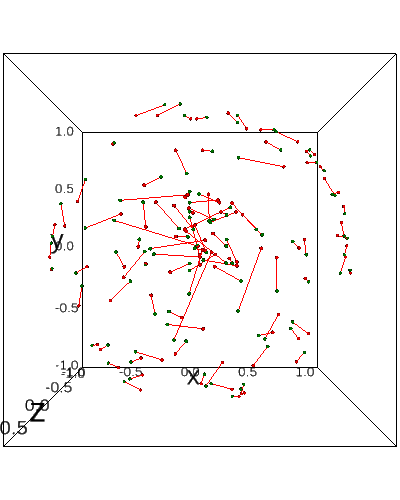

In [34]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [35]:
display(ipv.screenshot())

Output()

---

In [ ]:
# TODO: 0.0

# TODO: 0.2

# TODO: 0.5

# TODO: 0.8